In [419]:
# インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error


# 線形回帰スクラッチ

線形回帰のクラスをスクラッチで作成していきます。NumPyなど最低限のライブラリのみを使いアルゴリズムを実装していきます。


以下に雛形を用意してあります。このScratchLinearRegressionクラスにコードを書き加えていってください。

In [503]:
# 作成したクラスの完全版

class ScratchLinearRegression():
    """
    線形回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証データに対する損失の記録

    """
    def __init__(self, num_iter, lr, no_bias, verbose):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.no_bias = no_bias
        self.verbose = verbose
        
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        

    def _preprocessing_data(self, X, y):
        """
        入力時にデータの状態を確認して整形する関数
        
        parameters
        -----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        
        """
        
        # サイズ確認
        if X.shape[0] != y.shape[0]:
            raise Exception("n_samples must be the same size")
        
        # ndarray変換
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(X, pd.Series):
            X = X.values.reshape((-1,1))
        
        if isinstance(y, pd.DataFrame):
            y = y.values
        if isinstance(y, pd.Series):
            y = y.values
        
        # Xが(n_samples,)のndarrayだった場合
        if X.shape[0] == X.size:
            X = X.reshape((-1,1))
        
        # no_bias=Falseで0列目にnp.onesを追加
        if self.no_bias == False:
            X = np.hstack((np.ones((X.shape[0],1)), X))
        
        # 配列のサイズを取得
        self.m = X.shape[0]
        self.n = X.shape[1]
        
        return X, y

        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        線形回帰を学習する。検証データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        if self.no_bias == False:
            self.coef_ = np.random.normal(1, 0.5, (X.shape[1]+1))
        else:
            self.coef_ = np.random.normal(1, 0.5, (X.shape[1]))
        
        #print(self.coef_)
        
        # データ整形とインスタンス変数の作成
        X, y = self._preprocessing_data(X, y)
        if (X_val is not None) and (y_val is not None):
            X_val, y_val = self._preprocessing_data(X_val, y_val)
        
        # 仮定関数から最初のhθ(X)を算出
        pred = self._linear_hypothesis(X)
        #print(pred)
        
        # メイン部分
        for i in range(self.iter):
            # errorを算出
            error = self._error_calc(X, y)
            # gradient_descentで最急降下法実施、coef_を更新
            self.coef_ = self._gradient_descent(X, error)
            # lossを算出、このlossを小さくしていくのがこのクラスの目的
            self.loss[i] = self._loss_function(X, y)
            #print(self.loss[i])
            
            # 検証データが変数に入れられていた場合、そっちも計算
            if (X_val is not None) and (y_val is not None):
                self.val_loss[i] = self._loss_function(X_val, y_val)
                if self.verbose == True:
                    print("iter : {} [val_loss : {:e}]".format(i, self.val_loss[i]))
            
            # 学習過程の出力可否
            if self.verbose == True:
                print("iter : {} [train_loss : {:e}]".format(i, self.loss[i]))        
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print()
        pass
        
        return self.coef_

    

    def predict(self, X):
        """
        学習した線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        # Xが(n_samples,)のndarrayだった場合
        if X.shape[0] == X.size:
            X = X.reshape((-1,1))
        
        # no_bias=Falseで0列目にnp.onesを追加
        if self.no_bias == False:
            X = np.hstack((np.ones((X.shape[0],1)), X))
        
            
        return self._linear_hypothesis(X)
    
    def _linear_hypothesis(self, X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """

        return np.dot(X, self.coef_)
    
    def _gradient_descent(self, X, error):
        """
        最急降下法で最適化を行う関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        y : 次の形のndarray, shape (n_samples)
        目的変数

        Returns
        -------
        次の形のndarray shape( n_features)
        θのarray
        
        """

    
        self.coef_ -= np.dot(error, X) * self.lr / X.shape[0]
        return self.coef_

    def _error_calc(self, X, y):
        """
        error を計算する関数
        
        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples)
        目的変数
        y_pred : 次の形のndarray, shape (n_samples)
         予測値

        Returns
        -------
        次の形のndarray, shape (n_samples)
        誤差のarray
        
        """
        pred = self._linear_hypothesis(X) 
        return pred - y     
    
    def _loss_function(self, X, y):
        """
        目的関数
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
         訓練データ
        y : 次の形のndarray, shape (n_samples)
         訓練データの正解値

        Returns
        -------
        次の形のndarray, numpy.float
        平均二乗誤差 / 2
        """
              
        #m = len(y)
        error = self._error_calc(X, y)
        loss = sum(error ** 2) / 2*self.m

        return loss
    
    




In [316]:
# テストデータ
X = np.array([[1, 5],[2, 8],[3, 9]])
y = np.arange(6, 9)
θ_0 = 5
θ_1 = 1
θ_2 = 0

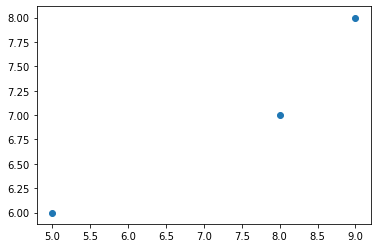

In [317]:
plt.scatter(X[:,1],y)
plt.show()

# 【問題1】仮定関数
以下の数式で表される線形回帰の仮定関数を実装してください。メソッドの雛形を用意してあります。

$
h_θ(x)=θ_0x_0+θ_1x_1+...+ θ_jx_j+...+ θ_nx_n.(x_0=1)
$


x : 特徴量ベクトル


θ : パラメータベクトル


n : 特徴量の数


xj : j番目の特徴量


θj : j番目のパラメータ（重み）


特徴量の数
n
は任意の値に対応できる実装にしてください。


なお、ベクトル形式で表すと以下のようになります。

$
h_θ(x)=θ^T⋅x.
$

In [377]:
# 問題1用の独立版。thetaは正解値を入れている。
def linear_hypothesis(X):
        """
        線形の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          訓練データ

        Returns
        -------
          次の形のndarray, shape (n_samples, 1)
          線形の仮定関数による推定結果

        """
        X = np.concatenate([np.ones((X.shape[0], 1)), X], 1)
        
        theta = np.array([5,1,0])
        h_theta_x = np.dot(X, theta)
        
        return h_theta_x

In [378]:
linear_hypothesis(X)

array([6., 7., 8.])

結果をscikit-learnの線形回帰と比較して確認する。


In [376]:
# scikit-learn
clf = linear_model.LinearRegression()
clf.fit(X,y)
y_pred_clf = clf.predict(X)
y_pred_clf

array([6., 7., 8.])

問題なさそう。

# 【問題2】最急降下法
最急降下法により学習させる実装を行なってください。以下の式で表されるパラメータの更新式のメソッド_gradient_descentを追加し、fit
メソッドから呼び出すようにしてください。

$
θ_j := θ_j−α\frac{1}{m} \sum_{i=1}^m [(h_θ(x^\left(i\right))−y^\left(i\right))x^\left(i\right)_j]
$


α : 学習率


i : サンプルのインデックス


j : 特徴量のインデックス


<b>雛形</b>


ScratchLinearRegressionクラスへ以下のメソッドを追加してください。コメントアウト部分の説明も記述してください。



In [407]:
# 問題２用の独立版。thetaは正解値を入れている。

def error_calc(X, y):
        """
        error を計算する関数
        
        Parameters
        ----------
        y : 次の形のndarray, shape (n_samples)
        目的変数
        y_pred : 次の形のndarray, shape (n_samples)
         予測値

        Returns
        -------
        次の形のndarray, shape (n_samples)
        誤差のarray
        
        """
        pred = linear_hypothesis(X) 
        return pred - y     


def gradient_descent(X, y):
        """
        最急降下法で最適化を行う関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        訓練データ
        y : 次の形のndarray, shape (n_samples)
        目的変数

        Returns
        -------
        次の形のndarray shape( n_features)
        θのarray
        
        """
        alpha = 0.001
        
        error = error_calc(X, y)
        coef = np.array([5,1,0])
        theta = coef - alpha/X.shape[0] * (np.array([[i] for i in error]) * X).sum(axis=1)
        
        return theta

    

In [408]:
gradient_descent(X, y)

array([5., 1., 0.])

結果をscikit-learnと比較して検証。

In [412]:
np.insert(clf.coef_, 0, clf.intercept_)

array([5.00000000e+00, 1.00000000e+00, 7.85046229e-17])

問題なさそう。

# 【問題3】推定
推定する仕組みを実装してください。ScratchLinearRegressionクラスの雛形に含まれるpredictメソッドに書き加えてください。


仮定関数 
$$
hθ(x)
$$
 の出力が推定結果です。

In [427]:
def predict(X):
        """
        学習した線形回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        # Xが(n_samples,)のndarrayだった場合
        if X.shape[0] == X.size:
            X = X.reshape((-1,1))
            
        return linear_hypothesis(X)

In [430]:
tmp =predict(X)
tmp

array([6., 7., 8.])

scikit-learnと比較。

In [433]:
clf.predict(X)

array([6., 7., 8.])

あっている。

# 【問題4】平均二乗誤差
線形回帰の指標値として用いられる平均二乗誤差（mean square error, MSE）の関数を作成してください。


平均二乗誤差関数は回帰問題全般で使える関数のため、ScratchLinearRegressionクラスのメソッドではなく、別の関数として作成してください。雛形を用意してあります。


平均二乗誤差は以下の数式で表されます。

$$
L(θ)=1mm∑i=1 (hθ(x(i))−y(i))2.
$$

m : 入力されるデータの数

hθ() : 仮定関数

x(i) : i番目のサンプルの特徴量ベクトル

y(i) : i番目のサンプルの正解値

なお、最急降下法のための目的関数（損失関数）としては、これを2で割ったものを使用します。（問題5, 9）

In [415]:
# mean_square_error
def MSE(X, y):
    """
    平均二乗誤差の計算

    Parameters
    ----------
    y_pred : 次の形のndarray, shape (n_samples,)
      推定した値
    y : 次の形のndarray, shape (n_samples,)
      正解値

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    m = len(y)
    
    y_pred = linear_hypothesis(X) 
    error = y_pred - y
    #print(error)
    
    mse = np.sum((error ** 2) , axis=0) / m
    
    pass
    return mse

In [420]:
MSE(X,y)

0.0

こちらも比較。

In [422]:
y_pred = linear_hypothesis(X) 
mean_squared_error(y,y_pred)

0.0

問題なさそう。

# 【問題5】目的関数
以下の数式で表される線形回帰の 目的関数（損失関数） を実装してください。そして、これをself.loss, self.val_lossに記録するようにしてください。

目的関数（損失関数） 

J(θ) は次の式です。

$$
J(θ)=12mm∑i=1 (hθ(x(i))−y(i))2.
$$

m : 入力されるデータの数

hθ() : 仮定関数

x(i) : i番目のサンプルの特徴量ベクトル

y(i) : i番目のサンプルの正解値

In [438]:
 def loss_function(X, y):
        """
        目的関数
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
         訓練データ
        y : 次の形のndarray, shape (n_samples)
         訓練データの正解値

        Returns
        -------
        次の形のndarray, numpy.float
        平均二乗誤差 / 2
        """
              
        m = len(X)
        error = error_calc(X, y)
        loss = sum(error ** 2) / 2*m

        return loss
    

In [439]:
loss_function(X,y)

0.0

# 【問題6】学習と推定
機械学習スクラッチ入門のSprintで用意したHouse Pricesコンペティションのデータに対してスクラッチ実装の学習と推定を行なってください。


scikit-learnによる実装と比べ、正しく動いているかを確認してください。

### まずデータ作る

In [538]:
data = pd.read_csv("train.csv")
df = pd.DataFrame(data=data, columns=['GrLivArea', 'YearBuilt','SalePrice'])
print(df)

X = df.iloc[:,0:2].values
y = df.iloc[:,2].values
test_X = df.iloc[:,0].values
print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=0.5, random_state=50)
print(X_train, X_test, y_train, y_test)

      GrLivArea  YearBuilt  SalePrice
0          1710       2003     208500
1          1262       1976     181500
2          1786       2001     223500
3          1717       1915     140000
4          2198       2000     250000
...         ...        ...        ...
1455       1647       1999     175000
1456       2073       1978     210000
1457       2340       1941     266500
1458       1078       1950     142125
1459       1256       1965     147500

[1460 rows x 3 columns]
[[1710 2003]
 [1262 1976]
 [1786 2001]
 ...
 [2340 1941]
 [1078 1950]
 [1256 1965]]
[208500 181500 223500 ... 266500 142125 147500]
[[1268 1949]
 [2345 1932]
 [ 800 1936]
 ...
 [1327 1959]
 [2599 1999]
 [1844 1977]] [[1466 2007]
 [1509 1988]
 [1302 1972]
 ...
 [1801 2005]
 [ 816 1982]
 [1440 1955]] [133000 239000  60000 172500 188700 377426 157000 107000 375000 128500
 208900 260000 200000 144000 111250 112000 131000 143000 173000 153337
 185500 192000 176500 175000 127500 150000 129900 320000 140000 269790
 13650

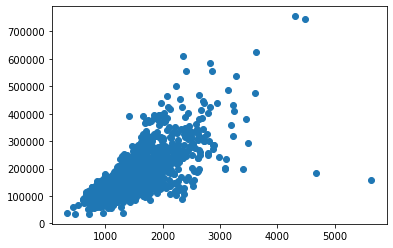

In [539]:
plt.scatter(X[:,0],y)

plt.show()

In [540]:
# 標準化する

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [541]:
# スクラッチ関数のインスタンス作成
scratch_ver = ScratchLinearRegression(num_iter=8000, lr=0.001, no_bias=False, verbose=True)

In [542]:
# テスト分も一気に計算
scratch_ver.fit(X_train_std,y_train_log, X_test_std, y_test_log)

iter : 0 [val_loss : 3.031767e+07]
iter : 0 [train_loss : 3.079702e+07]
iter : 1 [val_loss : 3.025706e+07]
iter : 1 [train_loss : 3.073541e+07]
iter : 2 [val_loss : 3.019657e+07]
iter : 2 [train_loss : 3.067393e+07]
iter : 3 [val_loss : 3.013621e+07]
iter : 3 [train_loss : 3.061257e+07]
iter : 4 [val_loss : 3.007596e+07]
iter : 4 [train_loss : 3.055133e+07]
iter : 5 [val_loss : 3.001584e+07]
iter : 5 [train_loss : 3.049022e+07]
iter : 6 [val_loss : 2.995583e+07]
iter : 6 [train_loss : 3.042922e+07]
iter : 7 [val_loss : 2.989595e+07]
iter : 7 [train_loss : 3.036835e+07]
iter : 8 [val_loss : 2.983618e+07]
iter : 8 [train_loss : 3.030761e+07]
iter : 9 [val_loss : 2.977654e+07]
iter : 9 [train_loss : 3.024698e+07]
iter : 10 [val_loss : 2.971701e+07]
iter : 10 [train_loss : 3.018647e+07]
iter : 11 [val_loss : 2.965760e+07]
iter : 11 [train_loss : 3.012609e+07]
iter : 12 [val_loss : 2.959832e+07]
iter : 12 [train_loss : 3.006583e+07]
iter : 13 [val_loss : 2.953915e+07]
iter : 13 [train_loss 

iter : 229 [val_loss : 1.917398e+07]
iter : 229 [train_loss : 1.947220e+07]
iter : 230 [val_loss : 1.913566e+07]
iter : 230 [train_loss : 1.943327e+07]
iter : 231 [val_loss : 1.909742e+07]
iter : 231 [train_loss : 1.939441e+07]
iter : 232 [val_loss : 1.905926e+07]
iter : 232 [train_loss : 1.935564e+07]
iter : 233 [val_loss : 1.902117e+07]
iter : 233 [train_loss : 1.931694e+07]
iter : 234 [val_loss : 1.898316e+07]
iter : 234 [train_loss : 1.927832e+07]
iter : 235 [val_loss : 1.894522e+07]
iter : 235 [train_loss : 1.923978e+07]
iter : 236 [val_loss : 1.890736e+07]
iter : 236 [train_loss : 1.920131e+07]
iter : 237 [val_loss : 1.886958e+07]
iter : 237 [train_loss : 1.916292e+07]
iter : 238 [val_loss : 1.883187e+07]
iter : 238 [train_loss : 1.912461e+07]
iter : 239 [val_loss : 1.879424e+07]
iter : 239 [train_loss : 1.908638e+07]
iter : 240 [val_loss : 1.875668e+07]
iter : 240 [train_loss : 1.904822e+07]
iter : 241 [val_loss : 1.871920e+07]
iter : 241 [train_loss : 1.901014e+07]
iter : 242 [

iter : 451 [val_loss : 1.229952e+07]
iter : 451 [train_loss : 1.248889e+07]
iter : 452 [val_loss : 1.227495e+07]
iter : 452 [train_loss : 1.246394e+07]
iter : 453 [val_loss : 1.225043e+07]
iter : 453 [train_loss : 1.243904e+07]
iter : 454 [val_loss : 1.222596e+07]
iter : 454 [train_loss : 1.241419e+07]
iter : 455 [val_loss : 1.220154e+07]
iter : 455 [train_loss : 1.238938e+07]
iter : 456 [val_loss : 1.217717e+07]
iter : 456 [train_loss : 1.236463e+07]
iter : 457 [val_loss : 1.215285e+07]
iter : 457 [train_loss : 1.233993e+07]
iter : 458 [val_loss : 1.212857e+07]
iter : 458 [train_loss : 1.231527e+07]
iter : 459 [val_loss : 1.210434e+07]
iter : 459 [train_loss : 1.229067e+07]
iter : 460 [val_loss : 1.208017e+07]
iter : 460 [train_loss : 1.226611e+07]
iter : 461 [val_loss : 1.205604e+07]
iter : 461 [train_loss : 1.224160e+07]
iter : 462 [val_loss : 1.203196e+07]
iter : 462 [train_loss : 1.221715e+07]
iter : 463 [val_loss : 1.200792e+07]
iter : 463 [train_loss : 1.219274e+07]
iter : 464 [

iter : 732 [val_loss : 7.014065e+06]
iter : 732 [train_loss : 7.121740e+06]
iter : 733 [val_loss : 7.000067e+06]
iter : 733 [train_loss : 7.107528e+06]
iter : 734 [val_loss : 6.986096e+06]
iter : 734 [train_loss : 7.093344e+06]
iter : 735 [val_loss : 6.972153e+06]
iter : 735 [train_loss : 7.079188e+06]
iter : 736 [val_loss : 6.958238e+06]
iter : 736 [train_loss : 7.065061e+06]
iter : 737 [val_loss : 6.944350e+06]
iter : 737 [train_loss : 7.050961e+06]
iter : 738 [val_loss : 6.930491e+06]
iter : 738 [train_loss : 7.036890e+06]
iter : 739 [val_loss : 6.916659e+06]
iter : 739 [train_loss : 7.022848e+06]
iter : 740 [val_loss : 6.902855e+06]
iter : 740 [train_loss : 7.008833e+06]
iter : 741 [val_loss : 6.889078e+06]
iter : 741 [train_loss : 6.994846e+06]
iter : 742 [val_loss : 6.875329e+06]
iter : 742 [train_loss : 6.980888e+06]
iter : 743 [val_loss : 6.861608e+06]
iter : 743 [train_loss : 6.966957e+06]
iter : 744 [val_loss : 6.847914e+06]
iter : 744 [train_loss : 6.953054e+06]
iter : 745 [

iter : 1028 [val_loss : 3.884320e+06]
iter : 1028 [train_loss : 3.944641e+06]
iter : 1029 [val_loss : 3.876579e+06]
iter : 1029 [train_loss : 3.936783e+06]
iter : 1030 [val_loss : 3.868853e+06]
iter : 1030 [train_loss : 3.928942e+06]
iter : 1031 [val_loss : 3.861143e+06]
iter : 1031 [train_loss : 3.921116e+06]
iter : 1032 [val_loss : 3.853448e+06]
iter : 1032 [train_loss : 3.913306e+06]
iter : 1033 [val_loss : 3.845769e+06]
iter : 1033 [train_loss : 3.905511e+06]
iter : 1034 [val_loss : 3.838104e+06]
iter : 1034 [train_loss : 3.897732e+06]
iter : 1035 [val_loss : 3.830456e+06]
iter : 1035 [train_loss : 3.889968e+06]
iter : 1036 [val_loss : 3.822822e+06]
iter : 1036 [train_loss : 3.882220e+06]
iter : 1037 [val_loss : 3.815204e+06]
iter : 1037 [train_loss : 3.874488e+06]
iter : 1038 [val_loss : 3.807601e+06]
iter : 1038 [train_loss : 3.866771e+06]
iter : 1039 [val_loss : 3.800013e+06]
iter : 1039 [train_loss : 3.859069e+06]
iter : 1040 [val_loss : 3.792440e+06]
iter : 1040 [train_loss : 

iter : 1320 [val_loss : 2.170757e+06]
iter : 1320 [train_loss : 2.205490e+06]
iter : 1321 [val_loss : 2.166442e+06]
iter : 1321 [train_loss : 2.201110e+06]
iter : 1322 [val_loss : 2.162135e+06]
iter : 1322 [train_loss : 2.196739e+06]
iter : 1323 [val_loss : 2.157837e+06]
iter : 1323 [train_loss : 2.192377e+06]
iter : 1324 [val_loss : 2.153547e+06]
iter : 1324 [train_loss : 2.188023e+06]
iter : 1325 [val_loss : 2.149266e+06]
iter : 1325 [train_loss : 2.183678e+06]
iter : 1326 [val_loss : 2.144993e+06]
iter : 1326 [train_loss : 2.179342e+06]
iter : 1327 [val_loss : 2.140729e+06]
iter : 1327 [train_loss : 2.175015e+06]
iter : 1328 [val_loss : 2.136474e+06]
iter : 1328 [train_loss : 2.170696e+06]
iter : 1329 [val_loss : 2.132227e+06]
iter : 1329 [train_loss : 2.166386e+06]
iter : 1330 [val_loss : 2.127988e+06]
iter : 1330 [train_loss : 2.162084e+06]
iter : 1331 [val_loss : 2.123758e+06]
iter : 1331 [train_loss : 2.157791e+06]
iter : 1332 [val_loss : 2.119536e+06]
iter : 1332 [train_loss : 

iter : 1594 [val_loss : 1.259614e+06]
iter : 1594 [train_loss : 1.280781e+06]
iter : 1595 [val_loss : 1.257120e+06]
iter : 1595 [train_loss : 1.278249e+06]
iter : 1596 [val_loss : 1.254631e+06]
iter : 1596 [train_loss : 1.275723e+06]
iter : 1597 [val_loss : 1.252147e+06]
iter : 1597 [train_loss : 1.273202e+06]
iter : 1598 [val_loss : 1.249667e+06]
iter : 1598 [train_loss : 1.270685e+06]
iter : 1599 [val_loss : 1.247193e+06]
iter : 1599 [train_loss : 1.268174e+06]
iter : 1600 [val_loss : 1.244724e+06]
iter : 1600 [train_loss : 1.265668e+06]
iter : 1601 [val_loss : 1.242260e+06]
iter : 1601 [train_loss : 1.263167e+06]
iter : 1602 [val_loss : 1.239800e+06]
iter : 1602 [train_loss : 1.260671e+06]
iter : 1603 [val_loss : 1.237346e+06]
iter : 1603 [train_loss : 1.258180e+06]
iter : 1604 [val_loss : 1.234896e+06]
iter : 1604 [train_loss : 1.255694e+06]
iter : 1605 [val_loss : 1.232451e+06]
iter : 1605 [train_loss : 1.253212e+06]
iter : 1606 [val_loss : 1.230011e+06]
iter : 1606 [train_loss : 

iter : 1821 [val_loss : 8.041315e+05]
iter : 1821 [train_loss : 8.184699e+05]
iter : 1822 [val_loss : 8.025479e+05]
iter : 1822 [train_loss : 8.168624e+05]
iter : 1823 [val_loss : 8.009674e+05]
iter : 1823 [train_loss : 8.152581e+05]
iter : 1824 [val_loss : 7.993901e+05]
iter : 1824 [train_loss : 8.136570e+05]
iter : 1825 [val_loss : 7.978160e+05]
iter : 1825 [train_loss : 8.120591e+05]
iter : 1826 [val_loss : 7.962450e+05]
iter : 1826 [train_loss : 8.104644e+05]
iter : 1827 [val_loss : 7.946771e+05]
iter : 1827 [train_loss : 8.088728e+05]
iter : 1828 [val_loss : 7.931124e+05]
iter : 1828 [train_loss : 8.072845e+05]
iter : 1829 [val_loss : 7.915508e+05]
iter : 1829 [train_loss : 8.056993e+05]
iter : 1830 [val_loss : 7.899923e+05]
iter : 1830 [train_loss : 8.041173e+05]
iter : 1831 [val_loss : 7.884370e+05]
iter : 1831 [train_loss : 8.025385e+05]
iter : 1832 [val_loss : 7.868847e+05]
iter : 1832 [train_loss : 8.009628e+05]
iter : 1833 [val_loss : 7.853356e+05]
iter : 1833 [train_loss : 

iter : 2115 [val_loss : 4.518167e+05]
iter : 2115 [train_loss : 4.607804e+05]
iter : 2116 [val_loss : 4.509374e+05]
iter : 2116 [train_loss : 4.598875e+05]
iter : 2117 [val_loss : 4.500598e+05]
iter : 2117 [train_loss : 4.589963e+05]
iter : 2118 [val_loss : 4.491840e+05]
iter : 2118 [train_loss : 4.581069e+05]
iter : 2119 [val_loss : 4.483099e+05]
iter : 2119 [train_loss : 4.572192e+05]
iter : 2120 [val_loss : 4.474376e+05]
iter : 2120 [train_loss : 4.563334e+05]
iter : 2121 [val_loss : 4.465670e+05]
iter : 2121 [train_loss : 4.554493e+05]
iter : 2122 [val_loss : 4.456982e+05]
iter : 2122 [train_loss : 4.545670e+05]
iter : 2123 [val_loss : 4.448311e+05]
iter : 2123 [train_loss : 4.536864e+05]
iter : 2124 [val_loss : 4.439657e+05]
iter : 2124 [train_loss : 4.528076e+05]
iter : 2125 [val_loss : 4.431020e+05]
iter : 2125 [train_loss : 4.519306e+05]
iter : 2126 [val_loss : 4.422401e+05]
iter : 2126 [train_loss : 4.510553e+05]
iter : 2127 [val_loss : 4.413799e+05]
iter : 2127 [train_loss : 

iter : 2404 [val_loss : 2.586468e+05]
iter : 2404 [train_loss : 2.645614e+05]
iter : 2405 [val_loss : 2.581536e+05]
iter : 2405 [train_loss : 2.640603e+05]
iter : 2406 [val_loss : 2.576614e+05]
iter : 2406 [train_loss : 2.635602e+05]
iter : 2407 [val_loss : 2.571703e+05]
iter : 2407 [train_loss : 2.630610e+05]
iter : 2408 [val_loss : 2.566801e+05]
iter : 2408 [train_loss : 2.625629e+05]
iter : 2409 [val_loss : 2.561908e+05]
iter : 2409 [train_loss : 2.620658e+05]
iter : 2410 [val_loss : 2.557026e+05]
iter : 2410 [train_loss : 2.615696e+05]
iter : 2411 [val_loss : 2.552153e+05]
iter : 2411 [train_loss : 2.610744e+05]
iter : 2412 [val_loss : 2.547290e+05]
iter : 2412 [train_loss : 2.605803e+05]
iter : 2413 [val_loss : 2.542437e+05]
iter : 2413 [train_loss : 2.600871e+05]
iter : 2414 [val_loss : 2.537594e+05]
iter : 2414 [train_loss : 2.595949e+05]
iter : 2415 [val_loss : 2.532760e+05]
iter : 2415 [train_loss : 2.591037e+05]
iter : 2416 [val_loss : 2.527936e+05]
iter : 2416 [train_loss : 

iter : 2649 [val_loss : 1.630494e+05]
iter : 2649 [train_loss : 1.673831e+05]
iter : 2650 [val_loss : 1.627474e+05]
iter : 2650 [train_loss : 1.670759e+05]
iter : 2651 [val_loss : 1.624460e+05]
iter : 2651 [train_loss : 1.667694e+05]
iter : 2652 [val_loss : 1.621452e+05]
iter : 2652 [train_loss : 1.664635e+05]
iter : 2653 [val_loss : 1.618450e+05]
iter : 2653 [train_loss : 1.661582e+05]
iter : 2654 [val_loss : 1.615454e+05]
iter : 2654 [train_loss : 1.658535e+05]
iter : 2655 [val_loss : 1.612464e+05]
iter : 2655 [train_loss : 1.655494e+05]
iter : 2656 [val_loss : 1.609480e+05]
iter : 2656 [train_loss : 1.652459e+05]
iter : 2657 [val_loss : 1.606502e+05]
iter : 2657 [train_loss : 1.649430e+05]
iter : 2658 [val_loss : 1.603530e+05]
iter : 2658 [train_loss : 1.646407e+05]
iter : 2659 [val_loss : 1.600564e+05]
iter : 2659 [train_loss : 1.643391e+05]
iter : 2660 [val_loss : 1.597604e+05]
iter : 2660 [train_loss : 1.640380e+05]
iter : 2661 [val_loss : 1.594649e+05]
iter : 2661 [train_loss : 

iter : 2925 [val_loss : 9.894467e+04]
iter : 2925 [train_loss : 1.021528e+05]
iter : 2926 [val_loss : 9.877088e+04]
iter : 2926 [train_loss : 1.019758e+05]
iter : 2927 [val_loss : 9.859743e+04]
iter : 2927 [train_loss : 1.017992e+05]
iter : 2928 [val_loss : 9.842433e+04]
iter : 2928 [train_loss : 1.016229e+05]
iter : 2929 [val_loss : 9.825157e+04]
iter : 2929 [train_loss : 1.014470e+05]
iter : 2930 [val_loss : 9.807916e+04]
iter : 2930 [train_loss : 1.012714e+05]
iter : 2931 [val_loss : 9.790709e+04]
iter : 2931 [train_loss : 1.010962e+05]
iter : 2932 [val_loss : 9.773537e+04]
iter : 2932 [train_loss : 1.009213e+05]
iter : 2933 [val_loss : 9.756399e+04]
iter : 2933 [train_loss : 1.007468e+05]
iter : 2934 [val_loss : 9.739296e+04]
iter : 2934 [train_loss : 1.005726e+05]
iter : 2935 [val_loss : 9.722227e+04]
iter : 2935 [train_loss : 1.003988e+05]
iter : 2936 [val_loss : 9.705192e+04]
iter : 2936 [train_loss : 1.002253e+05]
iter : 2937 [val_loss : 9.688190e+04]
iter : 2937 [train_loss : 

iter : 3222 [val_loss : 5.999919e+04]
iter : 3222 [train_loss : 6.246333e+04]
iter : 3223 [val_loss : 5.990331e+04]
iter : 3223 [train_loss : 6.236552e+04]
iter : 3224 [val_loss : 5.980763e+04]
iter : 3224 [train_loss : 6.226790e+04]
iter : 3225 [val_loss : 5.971214e+04]
iter : 3225 [train_loss : 6.217048e+04]
iter : 3226 [val_loss : 5.961684e+04]
iter : 3226 [train_loss : 6.207326e+04]
iter : 3227 [val_loss : 5.952173e+04]
iter : 3227 [train_loss : 6.197622e+04]
iter : 3228 [val_loss : 5.942682e+04]
iter : 3228 [train_loss : 6.187938e+04]
iter : 3229 [val_loss : 5.933209e+04]
iter : 3229 [train_loss : 6.178274e+04]
iter : 3230 [val_loss : 5.923755e+04]
iter : 3230 [train_loss : 6.168629e+04]
iter : 3231 [val_loss : 5.914320e+04]
iter : 3231 [train_loss : 6.159002e+04]
iter : 3232 [val_loss : 5.904904e+04]
iter : 3232 [train_loss : 6.149396e+04]
iter : 3233 [val_loss : 5.895507e+04]
iter : 3233 [train_loss : 6.139808e+04]
iter : 3234 [val_loss : 5.886128e+04]
iter : 3234 [train_loss : 

iter : 3510 [val_loss : 3.899939e+04]
iter : 3510 [train_loss : 4.101677e+04]
iter : 3511 [val_loss : 3.894557e+04]
iter : 3511 [train_loss : 4.096171e+04]
iter : 3512 [val_loss : 3.889184e+04]
iter : 3512 [train_loss : 4.090677e+04]
iter : 3513 [val_loss : 3.883823e+04]
iter : 3513 [train_loss : 4.085194e+04]
iter : 3514 [val_loss : 3.878472e+04]
iter : 3514 [train_loss : 4.079721e+04]
iter : 3515 [val_loss : 3.873132e+04]
iter : 3515 [train_loss : 4.074260e+04]
iter : 3516 [val_loss : 3.867803e+04]
iter : 3516 [train_loss : 4.068809e+04]
iter : 3517 [val_loss : 3.862484e+04]
iter : 3517 [train_loss : 4.063370e+04]
iter : 3518 [val_loss : 3.857177e+04]
iter : 3518 [train_loss : 4.057941e+04]
iter : 3519 [val_loss : 3.851879e+04]
iter : 3519 [train_loss : 4.052523e+04]
iter : 3520 [val_loss : 3.846593e+04]
iter : 3520 [train_loss : 4.047115e+04]
iter : 3521 [val_loss : 3.841316e+04]
iter : 3521 [train_loss : 4.041719e+04]
iter : 3522 [val_loss : 3.836051e+04]
iter : 3522 [train_loss : 

iter : 3797 [val_loss : 2.724167e+04]
iter : 3797 [train_loss : 2.897503e+04]
iter : 3798 [val_loss : 2.721140e+04]
iter : 3798 [train_loss : 2.894398e+04]
iter : 3799 [val_loss : 2.718119e+04]
iter : 3799 [train_loss : 2.891298e+04]
iter : 3800 [val_loss : 2.715105e+04]
iter : 3800 [train_loss : 2.888205e+04]
iter : 3801 [val_loss : 2.712096e+04]
iter : 3801 [train_loss : 2.885117e+04]
iter : 3802 [val_loss : 2.709093e+04]
iter : 3802 [train_loss : 2.882036e+04]
iter : 3803 [val_loss : 2.706097e+04]
iter : 3803 [train_loss : 2.878961e+04]
iter : 3804 [val_loss : 2.703106e+04]
iter : 3804 [train_loss : 2.875893e+04]
iter : 3805 [val_loss : 2.700122e+04]
iter : 3805 [train_loss : 2.872830e+04]
iter : 3806 [val_loss : 2.697143e+04]
iter : 3806 [train_loss : 2.869773e+04]
iter : 3807 [val_loss : 2.694170e+04]
iter : 3807 [train_loss : 2.866723e+04]
iter : 3808 [val_loss : 2.691204e+04]
iter : 3808 [train_loss : 2.863678e+04]
iter : 3809 [val_loss : 2.688243e+04]
iter : 3809 [train_loss : 

iter : 4084 [val_loss : 2.063247e+04]
iter : 4084 [train_loss : 2.218080e+04]
iter : 4085 [val_loss : 2.061546e+04]
iter : 4085 [train_loss : 2.216328e+04]
iter : 4086 [val_loss : 2.059849e+04]
iter : 4086 [train_loss : 2.214578e+04]
iter : 4087 [val_loss : 2.058155e+04]
iter : 4087 [train_loss : 2.212833e+04]
iter : 4088 [val_loss : 2.056465e+04]
iter : 4088 [train_loss : 2.211091e+04]
iter : 4089 [val_loss : 2.054778e+04]
iter : 4089 [train_loss : 2.209352e+04]
iter : 4090 [val_loss : 2.053094e+04]
iter : 4090 [train_loss : 2.207617e+04]
iter : 4091 [val_loss : 2.051414e+04]
iter : 4091 [train_loss : 2.205885e+04]
iter : 4092 [val_loss : 2.049737e+04]
iter : 4092 [train_loss : 2.204156e+04]
iter : 4093 [val_loss : 2.048063e+04]
iter : 4093 [train_loss : 2.202431e+04]
iter : 4094 [val_loss : 2.046393e+04]
iter : 4094 [train_loss : 2.200710e+04]
iter : 4095 [val_loss : 2.044726e+04]
iter : 4095 [train_loss : 2.198992e+04]
iter : 4096 [val_loss : 2.043063e+04]
iter : 4096 [train_loss : 

iter : 4369 [val_loss : 1.693974e+04]
iter : 4369 [train_loss : 1.836587e+04]
iter : 4370 [val_loss : 1.693016e+04]
iter : 4370 [train_loss : 1.835594e+04]
iter : 4371 [val_loss : 1.692059e+04]
iter : 4371 [train_loss : 1.834602e+04]
iter : 4372 [val_loss : 1.691105e+04]
iter : 4372 [train_loss : 1.833613e+04]
iter : 4373 [val_loss : 1.690152e+04]
iter : 4373 [train_loss : 1.832625e+04]
iter : 4374 [val_loss : 1.689201e+04]
iter : 4374 [train_loss : 1.831640e+04]
iter : 4375 [val_loss : 1.688253e+04]
iter : 4375 [train_loss : 1.830656e+04]
iter : 4376 [val_loss : 1.687306e+04]
iter : 4376 [train_loss : 1.829675e+04]
iter : 4377 [val_loss : 1.686361e+04]
iter : 4377 [train_loss : 1.828695e+04]
iter : 4378 [val_loss : 1.685418e+04]
iter : 4378 [train_loss : 1.827717e+04]
iter : 4379 [val_loss : 1.684476e+04]
iter : 4379 [train_loss : 1.826742e+04]
iter : 4380 [val_loss : 1.683537e+04]
iter : 4380 [train_loss : 1.825768e+04]
iter : 4381 [val_loss : 1.682600e+04]
iter : 4381 [train_loss : 

iter : 4643 [val_loss : 1.492003e+04]
iter : 4643 [train_loss : 1.626594e+04]
iter : 4644 [val_loss : 1.491451e+04]
iter : 4644 [train_loss : 1.626019e+04]
iter : 4645 [val_loss : 1.490901e+04]
iter : 4645 [train_loss : 1.625444e+04]
iter : 4646 [val_loss : 1.490352e+04]
iter : 4646 [train_loss : 1.624870e+04]
iter : 4647 [val_loss : 1.489803e+04]
iter : 4647 [train_loss : 1.624298e+04]
iter : 4648 [val_loss : 1.489256e+04]
iter : 4648 [train_loss : 1.623727e+04]
iter : 4649 [val_loss : 1.488711e+04]
iter : 4649 [train_loss : 1.623157e+04]
iter : 4650 [val_loss : 1.488166e+04]
iter : 4650 [train_loss : 1.622588e+04]
iter : 4651 [val_loss : 1.487622e+04]
iter : 4651 [train_loss : 1.622020e+04]
iter : 4652 [val_loss : 1.487079e+04]
iter : 4652 [train_loss : 1.621454e+04]
iter : 4653 [val_loss : 1.486538e+04]
iter : 4653 [train_loss : 1.620888e+04]
iter : 4654 [val_loss : 1.485997e+04]
iter : 4654 [train_loss : 1.620324e+04]
iter : 4655 [val_loss : 1.485458e+04]
iter : 4655 [train_loss : 

iter : 4942 [val_loss : 1.368152e+04]
iter : 4942 [train_loss : 1.496719e+04]
iter : 4943 [val_loss : 1.367851e+04]
iter : 4943 [train_loss : 1.496402e+04]
iter : 4944 [val_loss : 1.367550e+04]
iter : 4944 [train_loss : 1.496085e+04]
iter : 4945 [val_loss : 1.367250e+04]
iter : 4945 [train_loss : 1.495768e+04]
iter : 4946 [val_loss : 1.366951e+04]
iter : 4946 [train_loss : 1.495453e+04]
iter : 4947 [val_loss : 1.366653e+04]
iter : 4947 [train_loss : 1.495137e+04]
iter : 4948 [val_loss : 1.366355e+04]
iter : 4948 [train_loss : 1.494823e+04]
iter : 4949 [val_loss : 1.366057e+04]
iter : 4949 [train_loss : 1.494509e+04]
iter : 4950 [val_loss : 1.365760e+04]
iter : 4950 [train_loss : 1.494196e+04]
iter : 4951 [val_loss : 1.365464e+04]
iter : 4951 [train_loss : 1.493883e+04]
iter : 4952 [val_loss : 1.365168e+04]
iter : 4952 [train_loss : 1.493571e+04]
iter : 4953 [val_loss : 1.364873e+04]
iter : 4953 [train_loss : 1.493260e+04]
iter : 4954 [val_loss : 1.364579e+04]
iter : 4954 [train_loss : 

iter : 5219 [val_loss : 1.304312e+04]
iter : 5219 [train_loss : 1.428999e+04]
iter : 5220 [val_loss : 1.304141e+04]
iter : 5220 [train_loss : 1.428815e+04]
iter : 5221 [val_loss : 1.303970e+04]
iter : 5221 [train_loss : 1.428633e+04]
iter : 5222 [val_loss : 1.303799e+04]
iter : 5222 [train_loss : 1.428450e+04]
iter : 5223 [val_loss : 1.303629e+04]
iter : 5223 [train_loss : 1.428268e+04]
iter : 5224 [val_loss : 1.303459e+04]
iter : 5224 [train_loss : 1.428086e+04]
iter : 5225 [val_loss : 1.303289e+04]
iter : 5225 [train_loss : 1.427905e+04]
iter : 5226 [val_loss : 1.303120e+04]
iter : 5226 [train_loss : 1.427724e+04]
iter : 5227 [val_loss : 1.302951e+04]
iter : 5227 [train_loss : 1.427543e+04]
iter : 5228 [val_loss : 1.302782e+04]
iter : 5228 [train_loss : 1.427363e+04]
iter : 5229 [val_loss : 1.302614e+04]
iter : 5229 [train_loss : 1.427183e+04]
iter : 5230 [val_loss : 1.302446e+04]
iter : 5230 [train_loss : 1.427004e+04]
iter : 5231 [val_loss : 1.302279e+04]
iter : 5231 [train_loss : 

iter : 5512 [val_loss : 1.266493e+04]
iter : 5512 [train_loss : 1.388273e+04]
iter : 5513 [val_loss : 1.266399e+04]
iter : 5513 [train_loss : 1.388170e+04]
iter : 5514 [val_loss : 1.266305e+04]
iter : 5514 [train_loss : 1.388068e+04]
iter : 5515 [val_loss : 1.266211e+04]
iter : 5515 [train_loss : 1.387966e+04]
iter : 5516 [val_loss : 1.266118e+04]
iter : 5516 [train_loss : 1.387864e+04]
iter : 5517 [val_loss : 1.266024e+04]
iter : 5517 [train_loss : 1.387763e+04]
iter : 5518 [val_loss : 1.265931e+04]
iter : 5518 [train_loss : 1.387662e+04]
iter : 5519 [val_loss : 1.265838e+04]
iter : 5519 [train_loss : 1.387560e+04]
iter : 5520 [val_loss : 1.265745e+04]
iter : 5520 [train_loss : 1.387459e+04]
iter : 5521 [val_loss : 1.265653e+04]
iter : 5521 [train_loss : 1.387359e+04]
iter : 5522 [val_loss : 1.265561e+04]
iter : 5522 [train_loss : 1.387258e+04]
iter : 5523 [val_loss : 1.265468e+04]
iter : 5523 [train_loss : 1.387158e+04]
iter : 5524 [val_loss : 1.265376e+04]
iter : 5524 [train_loss : 

iter : 5802 [val_loss : 1.245936e+04]
iter : 5802 [train_loss : 1.365676e+04]
iter : 5803 [val_loss : 1.245885e+04]
iter : 5803 [train_loss : 1.365618e+04]
iter : 5804 [val_loss : 1.245833e+04]
iter : 5804 [train_loss : 1.365561e+04]
iter : 5805 [val_loss : 1.245782e+04]
iter : 5805 [train_loss : 1.365503e+04]
iter : 5806 [val_loss : 1.245730e+04]
iter : 5806 [train_loss : 1.365446e+04]
iter : 5807 [val_loss : 1.245679e+04]
iter : 5807 [train_loss : 1.365389e+04]
iter : 5808 [val_loss : 1.245628e+04]
iter : 5808 [train_loss : 1.365332e+04]
iter : 5809 [val_loss : 1.245577e+04]
iter : 5809 [train_loss : 1.365275e+04]
iter : 5810 [val_loss : 1.245526e+04]
iter : 5810 [train_loss : 1.365218e+04]
iter : 5811 [val_loss : 1.245475e+04]
iter : 5811 [train_loss : 1.365162e+04]
iter : 5812 [val_loss : 1.245424e+04]
iter : 5812 [train_loss : 1.365105e+04]
iter : 5813 [val_loss : 1.245374e+04]
iter : 5813 [train_loss : 1.365049e+04]
iter : 5814 [val_loss : 1.245323e+04]
iter : 5814 [train_loss : 

iter : 6083 [val_loss : 1.234938e+04]
iter : 6083 [train_loss : 1.353253e+04]
iter : 6084 [val_loss : 1.234910e+04]
iter : 6084 [train_loss : 1.353220e+04]
iter : 6085 [val_loss : 1.234881e+04]
iter : 6085 [train_loss : 1.353187e+04]
iter : 6086 [val_loss : 1.234852e+04]
iter : 6086 [train_loss : 1.353154e+04]
iter : 6087 [val_loss : 1.234824e+04]
iter : 6087 [train_loss : 1.353121e+04]
iter : 6088 [val_loss : 1.234795e+04]
iter : 6088 [train_loss : 1.353088e+04]
iter : 6089 [val_loss : 1.234767e+04]
iter : 6089 [train_loss : 1.353056e+04]
iter : 6090 [val_loss : 1.234739e+04]
iter : 6090 [train_loss : 1.353023e+04]
iter : 6091 [val_loss : 1.234710e+04]
iter : 6091 [train_loss : 1.352991e+04]
iter : 6092 [val_loss : 1.234682e+04]
iter : 6092 [train_loss : 1.352958e+04]
iter : 6093 [val_loss : 1.234654e+04]
iter : 6093 [train_loss : 1.352926e+04]
iter : 6094 [val_loss : 1.234626e+04]
iter : 6094 [train_loss : 1.352893e+04]
iter : 6095 [val_loss : 1.234598e+04]
iter : 6095 [train_loss : 

iter : 6371 [val_loss : 1.228746e+04]
iter : 6371 [train_loss : 1.345998e+04]
iter : 6372 [val_loss : 1.228730e+04]
iter : 6372 [train_loss : 1.345979e+04]
iter : 6373 [val_loss : 1.228715e+04]
iter : 6373 [train_loss : 1.345961e+04]
iter : 6374 [val_loss : 1.228699e+04]
iter : 6374 [train_loss : 1.345942e+04]
iter : 6375 [val_loss : 1.228684e+04]
iter : 6375 [train_loss : 1.345924e+04]
iter : 6376 [val_loss : 1.228668e+04]
iter : 6376 [train_loss : 1.345905e+04]
iter : 6377 [val_loss : 1.228653e+04]
iter : 6377 [train_loss : 1.345887e+04]
iter : 6378 [val_loss : 1.228637e+04]
iter : 6378 [train_loss : 1.345868e+04]
iter : 6379 [val_loss : 1.228622e+04]
iter : 6379 [train_loss : 1.345850e+04]
iter : 6380 [val_loss : 1.228607e+04]
iter : 6380 [train_loss : 1.345831e+04]
iter : 6381 [val_loss : 1.228592e+04]
iter : 6381 [train_loss : 1.345813e+04]
iter : 6382 [val_loss : 1.228576e+04]
iter : 6382 [train_loss : 1.345795e+04]
iter : 6383 [val_loss : 1.228561e+04]
iter : 6383 [train_loss : 

iter : 6656 [val_loss : 1.225439e+04]
iter : 6656 [train_loss : 1.341924e+04]
iter : 6657 [val_loss : 1.225430e+04]
iter : 6657 [train_loss : 1.341913e+04]
iter : 6658 [val_loss : 1.225422e+04]
iter : 6658 [train_loss : 1.341903e+04]
iter : 6659 [val_loss : 1.225414e+04]
iter : 6659 [train_loss : 1.341892e+04]
iter : 6660 [val_loss : 1.225405e+04]
iter : 6660 [train_loss : 1.341882e+04]
iter : 6661 [val_loss : 1.225397e+04]
iter : 6661 [train_loss : 1.341871e+04]
iter : 6662 [val_loss : 1.225389e+04]
iter : 6662 [train_loss : 1.341861e+04]
iter : 6663 [val_loss : 1.225381e+04]
iter : 6663 [train_loss : 1.341850e+04]
iter : 6664 [val_loss : 1.225372e+04]
iter : 6664 [train_loss : 1.341840e+04]
iter : 6665 [val_loss : 1.225364e+04]
iter : 6665 [train_loss : 1.341829e+04]
iter : 6666 [val_loss : 1.225356e+04]
iter : 6666 [train_loss : 1.341819e+04]
iter : 6667 [val_loss : 1.225348e+04]
iter : 6667 [train_loss : 1.341808e+04]
iter : 6668 [val_loss : 1.225340e+04]
iter : 6668 [train_loss : 

iter : 6944 [val_loss : 1.223668e+04]
iter : 6944 [train_loss : 1.339584e+04]
iter : 6945 [val_loss : 1.223663e+04]
iter : 6945 [train_loss : 1.339578e+04]
iter : 6946 [val_loss : 1.223659e+04]
iter : 6946 [train_loss : 1.339572e+04]
iter : 6947 [val_loss : 1.223654e+04]
iter : 6947 [train_loss : 1.339566e+04]
iter : 6948 [val_loss : 1.223650e+04]
iter : 6948 [train_loss : 1.339560e+04]
iter : 6949 [val_loss : 1.223646e+04]
iter : 6949 [train_loss : 1.339554e+04]
iter : 6950 [val_loss : 1.223642e+04]
iter : 6950 [train_loss : 1.339548e+04]
iter : 6951 [val_loss : 1.223637e+04]
iter : 6951 [train_loss : 1.339542e+04]
iter : 6952 [val_loss : 1.223633e+04]
iter : 6952 [train_loss : 1.339536e+04]
iter : 6953 [val_loss : 1.223629e+04]
iter : 6953 [train_loss : 1.339530e+04]
iter : 6954 [val_loss : 1.223625e+04]
iter : 6954 [train_loss : 1.339525e+04]
iter : 6955 [val_loss : 1.223620e+04]
iter : 6955 [train_loss : 1.339519e+04]
iter : 6956 [val_loss : 1.223616e+04]
iter : 6956 [train_loss : 

iter : 7230 [val_loss : 1.222763e+04]
iter : 7230 [train_loss : 1.338264e+04]
iter : 7231 [val_loss : 1.222761e+04]
iter : 7231 [train_loss : 1.338261e+04]
iter : 7232 [val_loss : 1.222759e+04]
iter : 7232 [train_loss : 1.338257e+04]
iter : 7233 [val_loss : 1.222757e+04]
iter : 7233 [train_loss : 1.338254e+04]
iter : 7234 [val_loss : 1.222755e+04]
iter : 7234 [train_loss : 1.338250e+04]
iter : 7235 [val_loss : 1.222752e+04]
iter : 7235 [train_loss : 1.338247e+04]
iter : 7236 [val_loss : 1.222750e+04]
iter : 7236 [train_loss : 1.338244e+04]
iter : 7237 [val_loss : 1.222748e+04]
iter : 7237 [train_loss : 1.338240e+04]
iter : 7238 [val_loss : 1.222746e+04]
iter : 7238 [train_loss : 1.338237e+04]
iter : 7239 [val_loss : 1.222744e+04]
iter : 7239 [train_loss : 1.338233e+04]
iter : 7240 [val_loss : 1.222742e+04]
iter : 7240 [train_loss : 1.338230e+04]
iter : 7241 [val_loss : 1.222739e+04]
iter : 7241 [train_loss : 1.338227e+04]
iter : 7242 [val_loss : 1.222737e+04]
iter : 7242 [train_loss : 

iter : 7519 [val_loss : 1.222315e+04]
iter : 7519 [train_loss : 1.337506e+04]
iter : 7520 [val_loss : 1.222314e+04]
iter : 7520 [train_loss : 1.337504e+04]
iter : 7521 [val_loss : 1.222313e+04]
iter : 7521 [train_loss : 1.337502e+04]
iter : 7522 [val_loss : 1.222312e+04]
iter : 7522 [train_loss : 1.337500e+04]
iter : 7523 [val_loss : 1.222311e+04]
iter : 7523 [train_loss : 1.337498e+04]
iter : 7524 [val_loss : 1.222310e+04]
iter : 7524 [train_loss : 1.337496e+04]
iter : 7525 [val_loss : 1.222309e+04]
iter : 7525 [train_loss : 1.337494e+04]
iter : 7526 [val_loss : 1.222308e+04]
iter : 7526 [train_loss : 1.337492e+04]
iter : 7527 [val_loss : 1.222307e+04]
iter : 7527 [train_loss : 1.337490e+04]
iter : 7528 [val_loss : 1.222306e+04]
iter : 7528 [train_loss : 1.337488e+04]
iter : 7529 [val_loss : 1.222305e+04]
iter : 7529 [train_loss : 1.337486e+04]
iter : 7530 [val_loss : 1.222304e+04]
iter : 7530 [train_loss : 1.337485e+04]
iter : 7531 [val_loss : 1.222303e+04]
iter : 7531 [train_loss : 

iter : 7793 [val_loss : 1.222121e+04]
iter : 7793 [train_loss : 1.337092e+04]
iter : 7794 [val_loss : 1.222121e+04]
iter : 7794 [train_loss : 1.337091e+04]
iter : 7795 [val_loss : 1.222120e+04]
iter : 7795 [train_loss : 1.337090e+04]
iter : 7796 [val_loss : 1.222120e+04]
iter : 7796 [train_loss : 1.337089e+04]
iter : 7797 [val_loss : 1.222119e+04]
iter : 7797 [train_loss : 1.337088e+04]
iter : 7798 [val_loss : 1.222119e+04]
iter : 7798 [train_loss : 1.337087e+04]
iter : 7799 [val_loss : 1.222119e+04]
iter : 7799 [train_loss : 1.337085e+04]
iter : 7800 [val_loss : 1.222118e+04]
iter : 7800 [train_loss : 1.337084e+04]
iter : 7801 [val_loss : 1.222118e+04]
iter : 7801 [train_loss : 1.337083e+04]
iter : 7802 [val_loss : 1.222117e+04]
iter : 7802 [train_loss : 1.337082e+04]
iter : 7803 [val_loss : 1.222117e+04]
iter : 7803 [train_loss : 1.337081e+04]
iter : 7804 [val_loss : 1.222116e+04]
iter : 7804 [train_loss : 1.337080e+04]
iter : 7805 [val_loss : 1.222116e+04]
iter : 7805 [train_loss : 

array([12.01310515,  0.23684467,  0.18591667])

In [543]:
# fitで得た係数を使って予測
print(scratch_ver.coef_)
y_pred_scratch = scratch_ver.predict(X_test_std)

[12.01310515  0.23684467  0.18591667]


In [544]:
# 予測結果
y_pred_scratch

array([12.21325035, 12.11889072, 11.93006079, 11.56430605, 12.43543244,
       12.25652713, 11.89502463, 11.9718819 , 11.83254926, 12.20015052,
       11.66949783, 12.14289377, 11.23036042, 12.16762668, 12.33708852,
       12.26873573, 12.05943736, 12.14950921, 12.37603791, 11.89605391,
       12.07177993, 12.48832335, 11.64372341, 12.29842746, 11.81775727,
       12.12933202, 12.32540067, 11.6947748 , 12.43239121, 12.3634466 ,
       11.79481089, 11.77052358, 12.27475528, 11.73811449, 11.86057213,
       11.79318571, 12.3215585 , 12.30713291, 11.40687923, 11.7186398 ,
       11.57883824, 12.19678543, 11.88083553, 12.00465447, 11.81062108,
       12.50181288, 11.89924949, 12.24511131, 12.27068477, 12.30273854,
       12.42325529, 12.32958592, 12.1274389 , 11.91140626, 12.60188857,
       12.30412314, 11.77250408, 11.68674738, 12.76879032, 12.91584282,
       11.84517202, 12.02324901, 12.17077859, 11.92407678, 12.52578447,
       12.00592024, 11.60719197, 12.21947902, 11.71936559, 11.77

In [545]:
# scikit-learnでも同じことやる
clf = linear_model.LinearRegression()
clf.fit(X_train_std,y_train_log)
print(clf.coef_)
print(clf.intercept_)

[0.23795444 0.18474061]
12.016677705498282


In [546]:
y_pred = clf.predict(X_test_std)

In [547]:
y_pred

array([12.21534554, 12.12179573, 11.93313528, 11.56896135, 12.43876637,
       12.25941813, 11.89898923, 11.97515235, 11.8355622 , 12.20435878,
       11.67444835, 12.14518643, 11.23358275, 12.17003524, 12.33989575,
       12.27122269, 12.06404055, 12.15361196, 12.37889587, 11.89824424,
       12.07505723, 12.49928505, 11.64776245, 12.30362334, 11.82346837,
       12.13116579, 12.32900974, 11.69786699, 12.43630393, 12.36624556,
       11.79784467, 11.77258697, 12.27740223, 11.74068494, 11.86450708,
       11.79634367, 12.32462244, 12.30993157, 11.41059921, 11.72118489,
       11.58435234, 12.19893526, 11.88334991, 12.01110952, 11.8141243 ,
       12.50532607, 11.90422227, 12.24781704, 12.27568477, 12.30525304,
       12.42633449, 12.33314872, 12.13124056, 11.91235068, 12.60639782,
       12.30684181, 11.77642173, 11.68934071, 12.77362036, 12.9222185 ,
       11.84758518, 12.02649658, 12.17405851, 11.92718912, 12.52934409,
       12.00941608, 11.61046681, 12.22206464, 11.7217823 , 11.77

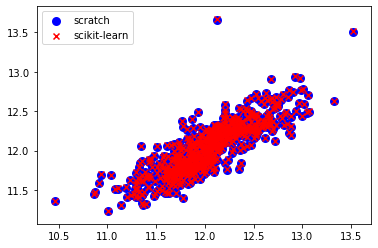

In [548]:
# scatterでプロットしてみる

plt.scatter(y_test_log, y_pred_scratch, linewidths="3", c='b', label='scratch')
plt.scatter(y_test_log, y_pred, marker="x", c='r', label='scikit-learn')
plt.legend()
plt.show()

<b>ほぼ同じ予想が出来ている。</b>

# 【問題7】学習曲線のプロット
学習曲線を表示する関数を作成し、実行してください。グラフを見て損失が適切に下がっているかどうか確認してください。


線形回帰クラスの雛形ではself.loss, self.val_lossに損失を記録しておくようになっているため、入力にはこれを利用してください。

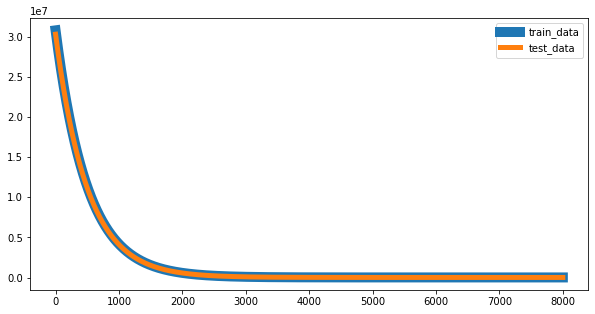

In [549]:
plt.figure(figsize=(10,5))

plt.plot([i for i in range(scratch_ver.iter)], scratch_ver.loss, linewidth = 10, label='train_data')
plt.plot([i for i in range(scratch_ver.iter)], scratch_ver.val_loss, linewidth = 5, label='test_data')
plt.legend()
plt.show()

あまりにも同じすぎる、、、合ってるか不安。

# 【問題8】（アドバンス課題）バイアス項の除去
バイアス項 
θ0
 を抜くと学習がどう変化するか検証してください。また、線形回帰モデルにおけるバイアス項の役割の考察・調査を行ってください。



In [550]:
# バイアスをTrueに
scratch_no_bias = ScratchLinearRegression(num_iter=8000, lr=0.001, no_bias=True, verbose=True)

In [551]:
scratch_no_bias.fit(X_train_std, y_train_log, X_test_std, y_test_log)

iter : 0 [val_loss : 3.883019e+07]
iter : 0 [train_loss : 3.945004e+07]
iter : 1 [val_loss : 3.882880e+07]
iter : 1 [train_loss : 3.944776e+07]
iter : 2 [val_loss : 3.882741e+07]
iter : 2 [train_loss : 3.944549e+07]
iter : 3 [val_loss : 3.882603e+07]
iter : 3 [train_loss : 3.944322e+07]
iter : 4 [val_loss : 3.882465e+07]
iter : 4 [train_loss : 3.944096e+07]
iter : 5 [val_loss : 3.882328e+07]
iter : 5 [train_loss : 3.943871e+07]
iter : 6 [val_loss : 3.882191e+07]
iter : 6 [train_loss : 3.943645e+07]
iter : 7 [val_loss : 3.882055e+07]
iter : 7 [train_loss : 3.943421e+07]
iter : 8 [val_loss : 3.881918e+07]
iter : 8 [train_loss : 3.943197e+07]
iter : 9 [val_loss : 3.881783e+07]
iter : 9 [train_loss : 3.942973e+07]
iter : 10 [val_loss : 3.881647e+07]
iter : 10 [train_loss : 3.942750e+07]
iter : 11 [val_loss : 3.881512e+07]
iter : 11 [train_loss : 3.942528e+07]
iter : 12 [val_loss : 3.881378e+07]
iter : 12 [train_loss : 3.942306e+07]
iter : 13 [val_loss : 3.881244e+07]
iter : 13 [train_loss 

iter : 232 [val_loss : 3.859796e+07]
iter : 232 [train_loss : 3.904430e+07]
iter : 233 [val_loss : 3.859728e+07]
iter : 233 [train_loss : 3.904299e+07]
iter : 234 [val_loss : 3.859660e+07]
iter : 234 [train_loss : 3.904169e+07]
iter : 235 [val_loss : 3.859592e+07]
iter : 235 [train_loss : 3.904039e+07]
iter : 236 [val_loss : 3.859525e+07]
iter : 236 [train_loss : 3.903909e+07]
iter : 237 [val_loss : 3.859457e+07]
iter : 237 [train_loss : 3.903780e+07]
iter : 238 [val_loss : 3.859390e+07]
iter : 238 [train_loss : 3.903651e+07]
iter : 239 [val_loss : 3.859323e+07]
iter : 239 [train_loss : 3.903522e+07]
iter : 240 [val_loss : 3.859256e+07]
iter : 240 [train_loss : 3.903394e+07]
iter : 241 [val_loss : 3.859190e+07]
iter : 241 [train_loss : 3.903266e+07]
iter : 242 [val_loss : 3.859124e+07]
iter : 242 [train_loss : 3.903138e+07]
iter : 243 [val_loss : 3.859057e+07]
iter : 243 [train_loss : 3.903011e+07]
iter : 244 [val_loss : 3.858992e+07]
iter : 244 [train_loss : 3.902883e+07]
iter : 245 [

iter : 459 [val_loss : 3.848903e+07]
iter : 459 [train_loss : 3.881521e+07]
iter : 460 [val_loss : 3.848871e+07]
iter : 460 [train_loss : 3.881445e+07]
iter : 461 [val_loss : 3.848840e+07]
iter : 461 [train_loss : 3.881370e+07]
iter : 462 [val_loss : 3.848809e+07]
iter : 462 [train_loss : 3.881294e+07]
iter : 463 [val_loss : 3.848777e+07]
iter : 463 [train_loss : 3.881218e+07]
iter : 464 [val_loss : 3.848746e+07]
iter : 464 [train_loss : 3.881143e+07]
iter : 465 [val_loss : 3.848716e+07]
iter : 465 [train_loss : 3.881068e+07]
iter : 466 [val_loss : 3.848685e+07]
iter : 466 [train_loss : 3.880993e+07]
iter : 467 [val_loss : 3.848654e+07]
iter : 467 [train_loss : 3.880919e+07]
iter : 468 [val_loss : 3.848624e+07]
iter : 468 [train_loss : 3.880844e+07]
iter : 469 [val_loss : 3.848593e+07]
iter : 469 [train_loss : 3.880770e+07]
iter : 470 [val_loss : 3.848563e+07]
iter : 470 [train_loss : 3.880695e+07]
iter : 471 [val_loss : 3.848533e+07]
iter : 471 [train_loss : 3.880621e+07]
iter : 472 [

iter : 745 [val_loss : 3.843532e+07]
iter : 745 [train_loss : 3.865721e+07]
iter : 746 [val_loss : 3.843522e+07]
iter : 746 [train_loss : 3.865682e+07]
iter : 747 [val_loss : 3.843513e+07]
iter : 747 [train_loss : 3.865643e+07]
iter : 748 [val_loss : 3.843504e+07]
iter : 748 [train_loss : 3.865605e+07]
iter : 749 [val_loss : 3.843495e+07]
iter : 749 [train_loss : 3.865567e+07]
iter : 750 [val_loss : 3.843486e+07]
iter : 750 [train_loss : 3.865528e+07]
iter : 751 [val_loss : 3.843477e+07]
iter : 751 [train_loss : 3.865490e+07]
iter : 752 [val_loss : 3.843468e+07]
iter : 752 [train_loss : 3.865452e+07]
iter : 753 [val_loss : 3.843460e+07]
iter : 753 [train_loss : 3.865414e+07]
iter : 754 [val_loss : 3.843451e+07]
iter : 754 [train_loss : 3.865376e+07]
iter : 755 [val_loss : 3.843442e+07]
iter : 755 [train_loss : 3.865338e+07]
iter : 756 [val_loss : 3.843433e+07]
iter : 756 [train_loss : 3.865301e+07]
iter : 757 [val_loss : 3.843425e+07]
iter : 757 [train_loss : 3.865263e+07]
iter : 758 [

iter : 996 [val_loss : 3.842419e+07]
iter : 996 [train_loss : 3.858385e+07]
iter : 997 [val_loss : 3.842418e+07]
iter : 997 [train_loss : 3.858363e+07]
iter : 998 [val_loss : 3.842417e+07]
iter : 998 [train_loss : 3.858342e+07]
iter : 999 [val_loss : 3.842417e+07]
iter : 999 [train_loss : 3.858321e+07]
iter : 1000 [val_loss : 3.842416e+07]
iter : 1000 [train_loss : 3.858299e+07]
iter : 1001 [val_loss : 3.842415e+07]
iter : 1001 [train_loss : 3.858278e+07]
iter : 1002 [val_loss : 3.842414e+07]
iter : 1002 [train_loss : 3.858257e+07]
iter : 1003 [val_loss : 3.842414e+07]
iter : 1003 [train_loss : 3.858236e+07]
iter : 1004 [val_loss : 3.842413e+07]
iter : 1004 [train_loss : 3.858215e+07]
iter : 1005 [val_loss : 3.842412e+07]
iter : 1005 [train_loss : 3.858193e+07]
iter : 1006 [val_loss : 3.842412e+07]
iter : 1006 [train_loss : 3.858172e+07]
iter : 1007 [val_loss : 3.842411e+07]
iter : 1007 [train_loss : 3.858151e+07]
iter : 1008 [val_loss : 3.842410e+07]
iter : 1008 [train_loss : 3.858131

iter : 1271 [val_loss : 3.842761e+07]
iter : 1271 [train_loss : 3.854016e+07]
iter : 1272 [val_loss : 3.842764e+07]
iter : 1272 [train_loss : 3.854004e+07]
iter : 1273 [val_loss : 3.842767e+07]
iter : 1273 [train_loss : 3.853993e+07]
iter : 1274 [val_loss : 3.842769e+07]
iter : 1274 [train_loss : 3.853982e+07]
iter : 1275 [val_loss : 3.842772e+07]
iter : 1275 [train_loss : 3.853970e+07]
iter : 1276 [val_loss : 3.842775e+07]
iter : 1276 [train_loss : 3.853959e+07]
iter : 1277 [val_loss : 3.842777e+07]
iter : 1277 [train_loss : 3.853948e+07]
iter : 1278 [val_loss : 3.842780e+07]
iter : 1278 [train_loss : 3.853937e+07]
iter : 1279 [val_loss : 3.842783e+07]
iter : 1279 [train_loss : 3.853925e+07]
iter : 1280 [val_loss : 3.842785e+07]
iter : 1280 [train_loss : 3.853914e+07]
iter : 1281 [val_loss : 3.842788e+07]
iter : 1281 [train_loss : 3.853903e+07]
iter : 1282 [val_loss : 3.842791e+07]
iter : 1282 [train_loss : 3.853892e+07]
iter : 1283 [val_loss : 3.842794e+07]
iter : 1283 [train_loss : 

iter : 1550 [val_loss : 3.843659e+07]
iter : 1550 [train_loss : 3.851668e+07]
iter : 1551 [val_loss : 3.843662e+07]
iter : 1551 [train_loss : 3.851662e+07]
iter : 1552 [val_loss : 3.843666e+07]
iter : 1552 [train_loss : 3.851656e+07]
iter : 1553 [val_loss : 3.843669e+07]
iter : 1553 [train_loss : 3.851650e+07]
iter : 1554 [val_loss : 3.843672e+07]
iter : 1554 [train_loss : 3.851644e+07]
iter : 1555 [val_loss : 3.843676e+07]
iter : 1555 [train_loss : 3.851638e+07]
iter : 1556 [val_loss : 3.843679e+07]
iter : 1556 [train_loss : 3.851632e+07]
iter : 1557 [val_loss : 3.843683e+07]
iter : 1557 [train_loss : 3.851626e+07]
iter : 1558 [val_loss : 3.843686e+07]
iter : 1558 [train_loss : 3.851620e+07]
iter : 1559 [val_loss : 3.843690e+07]
iter : 1559 [train_loss : 3.851614e+07]
iter : 1560 [val_loss : 3.843693e+07]
iter : 1560 [train_loss : 3.851609e+07]
iter : 1561 [val_loss : 3.843697e+07]
iter : 1561 [train_loss : 3.851603e+07]
iter : 1562 [val_loss : 3.843700e+07]
iter : 1562 [train_loss : 

iter : 1832 [val_loss : 3.844615e+07]
iter : 1832 [train_loss : 3.850408e+07]
iter : 1833 [val_loss : 3.844618e+07]
iter : 1833 [train_loss : 3.850405e+07]
iter : 1834 [val_loss : 3.844621e+07]
iter : 1834 [train_loss : 3.850402e+07]
iter : 1835 [val_loss : 3.844624e+07]
iter : 1835 [train_loss : 3.850398e+07]
iter : 1836 [val_loss : 3.844627e+07]
iter : 1836 [train_loss : 3.850395e+07]
iter : 1837 [val_loss : 3.844630e+07]
iter : 1837 [train_loss : 3.850392e+07]
iter : 1838 [val_loss : 3.844634e+07]
iter : 1838 [train_loss : 3.850389e+07]
iter : 1839 [val_loss : 3.844637e+07]
iter : 1839 [train_loss : 3.850386e+07]
iter : 1840 [val_loss : 3.844640e+07]
iter : 1840 [train_loss : 3.850383e+07]
iter : 1841 [val_loss : 3.844643e+07]
iter : 1841 [train_loss : 3.850379e+07]
iter : 1842 [val_loss : 3.844646e+07]
iter : 1842 [train_loss : 3.850376e+07]
iter : 1843 [val_loss : 3.844650e+07]
iter : 1843 [train_loss : 3.850373e+07]
iter : 1844 [val_loss : 3.844653e+07]
iter : 1844 [train_loss : 

iter : 2099 [val_loss : 3.845391e+07]
iter : 2099 [train_loss : 3.849759e+07]
iter : 2100 [val_loss : 3.845393e+07]
iter : 2100 [train_loss : 3.849757e+07]
iter : 2101 [val_loss : 3.845396e+07]
iter : 2101 [train_loss : 3.849756e+07]
iter : 2102 [val_loss : 3.845399e+07]
iter : 2102 [train_loss : 3.849754e+07]
iter : 2103 [val_loss : 3.845401e+07]
iter : 2103 [train_loss : 3.849752e+07]
iter : 2104 [val_loss : 3.845404e+07]
iter : 2104 [train_loss : 3.849750e+07]
iter : 2105 [val_loss : 3.845406e+07]
iter : 2105 [train_loss : 3.849749e+07]
iter : 2106 [val_loss : 3.845409e+07]
iter : 2106 [train_loss : 3.849747e+07]
iter : 2107 [val_loss : 3.845412e+07]
iter : 2107 [train_loss : 3.849745e+07]
iter : 2108 [val_loss : 3.845414e+07]
iter : 2108 [train_loss : 3.849743e+07]
iter : 2109 [val_loss : 3.845417e+07]
iter : 2109 [train_loss : 3.849742e+07]
iter : 2110 [val_loss : 3.845419e+07]
iter : 2110 [train_loss : 3.849740e+07]
iter : 2111 [val_loss : 3.845422e+07]
iter : 2111 [train_loss : 

iter : 2342 [val_loss : 3.845953e+07]
iter : 2342 [train_loss : 3.849420e+07]
iter : 2343 [val_loss : 3.845955e+07]
iter : 2343 [train_loss : 3.849419e+07]
iter : 2344 [val_loss : 3.845957e+07]
iter : 2344 [train_loss : 3.849418e+07]
iter : 2345 [val_loss : 3.845959e+07]
iter : 2345 [train_loss : 3.849417e+07]
iter : 2346 [val_loss : 3.845961e+07]
iter : 2346 [train_loss : 3.849416e+07]
iter : 2347 [val_loss : 3.845963e+07]
iter : 2347 [train_loss : 3.849415e+07]
iter : 2348 [val_loss : 3.845965e+07]
iter : 2348 [train_loss : 3.849414e+07]
iter : 2349 [val_loss : 3.845967e+07]
iter : 2349 [train_loss : 3.849413e+07]
iter : 2350 [val_loss : 3.845969e+07]
iter : 2350 [train_loss : 3.849412e+07]
iter : 2351 [val_loss : 3.845971e+07]
iter : 2351 [train_loss : 3.849411e+07]
iter : 2352 [val_loss : 3.845973e+07]
iter : 2352 [train_loss : 3.849410e+07]
iter : 2353 [val_loss : 3.845975e+07]
iter : 2353 [train_loss : 3.849409e+07]
iter : 2354 [val_loss : 3.845977e+07]
iter : 2354 [train_loss : 

iter : 2626 [val_loss : 3.846446e+07]
iter : 2626 [train_loss : 3.849192e+07]
iter : 2627 [val_loss : 3.846447e+07]
iter : 2627 [train_loss : 3.849192e+07]
iter : 2628 [val_loss : 3.846449e+07]
iter : 2628 [train_loss : 3.849191e+07]
iter : 2629 [val_loss : 3.846450e+07]
iter : 2629 [train_loss : 3.849190e+07]
iter : 2630 [val_loss : 3.846451e+07]
iter : 2630 [train_loss : 3.849190e+07]
iter : 2631 [val_loss : 3.846453e+07]
iter : 2631 [train_loss : 3.849189e+07]
iter : 2632 [val_loss : 3.846454e+07]
iter : 2632 [train_loss : 3.849189e+07]
iter : 2633 [val_loss : 3.846456e+07]
iter : 2633 [train_loss : 3.849188e+07]
iter : 2634 [val_loss : 3.846457e+07]
iter : 2634 [train_loss : 3.849187e+07]
iter : 2635 [val_loss : 3.846459e+07]
iter : 2635 [train_loss : 3.849187e+07]
iter : 2636 [val_loss : 3.846460e+07]
iter : 2636 [train_loss : 3.849186e+07]
iter : 2637 [val_loss : 3.846462e+07]
iter : 2637 [train_loss : 3.849186e+07]
iter : 2638 [val_loss : 3.846463e+07]
iter : 2638 [train_loss : 

iter : 2907 [val_loss : 3.846788e+07]
iter : 2907 [train_loss : 3.849066e+07]
iter : 2908 [val_loss : 3.846789e+07]
iter : 2908 [train_loss : 3.849066e+07]
iter : 2909 [val_loss : 3.846790e+07]
iter : 2909 [train_loss : 3.849065e+07]
iter : 2910 [val_loss : 3.846791e+07]
iter : 2910 [train_loss : 3.849065e+07]
iter : 2911 [val_loss : 3.846792e+07]
iter : 2911 [train_loss : 3.849065e+07]
iter : 2912 [val_loss : 3.846793e+07]
iter : 2912 [train_loss : 3.849064e+07]
iter : 2913 [val_loss : 3.846794e+07]
iter : 2913 [train_loss : 3.849064e+07]
iter : 2914 [val_loss : 3.846795e+07]
iter : 2914 [train_loss : 3.849064e+07]
iter : 2915 [val_loss : 3.846796e+07]
iter : 2915 [train_loss : 3.849063e+07]
iter : 2916 [val_loss : 3.846797e+07]
iter : 2916 [train_loss : 3.849063e+07]
iter : 2917 [val_loss : 3.846798e+07]
iter : 2917 [train_loss : 3.849063e+07]
iter : 2918 [val_loss : 3.846799e+07]
iter : 2918 [train_loss : 3.849062e+07]
iter : 2919 [val_loss : 3.846800e+07]
iter : 2919 [train_loss : 

iter : 3148 [val_loss : 3.846993e+07]
iter : 3148 [train_loss : 3.849002e+07]
iter : 3149 [val_loss : 3.846994e+07]
iter : 3149 [train_loss : 3.849002e+07]
iter : 3150 [val_loss : 3.846994e+07]
iter : 3150 [train_loss : 3.849002e+07]
iter : 3151 [val_loss : 3.846995e+07]
iter : 3151 [train_loss : 3.849001e+07]
iter : 3152 [val_loss : 3.846996e+07]
iter : 3152 [train_loss : 3.849001e+07]
iter : 3153 [val_loss : 3.846996e+07]
iter : 3153 [train_loss : 3.849001e+07]
iter : 3154 [val_loss : 3.846997e+07]
iter : 3154 [train_loss : 3.849001e+07]
iter : 3155 [val_loss : 3.846998e+07]
iter : 3155 [train_loss : 3.849001e+07]
iter : 3156 [val_loss : 3.846999e+07]
iter : 3156 [train_loss : 3.849000e+07]
iter : 3157 [val_loss : 3.846999e+07]
iter : 3157 [train_loss : 3.849000e+07]
iter : 3158 [val_loss : 3.847000e+07]
iter : 3158 [train_loss : 3.849000e+07]
iter : 3159 [val_loss : 3.847001e+07]
iter : 3159 [train_loss : 3.849000e+07]
iter : 3160 [val_loss : 3.847001e+07]
iter : 3160 [train_loss : 

iter : 3428 [val_loss : 3.847154e+07]
iter : 3428 [train_loss : 3.848957e+07]
iter : 3429 [val_loss : 3.847155e+07]
iter : 3429 [train_loss : 3.848957e+07]
iter : 3430 [val_loss : 3.847155e+07]
iter : 3430 [train_loss : 3.848957e+07]
iter : 3431 [val_loss : 3.847155e+07]
iter : 3431 [train_loss : 3.848957e+07]
iter : 3432 [val_loss : 3.847156e+07]
iter : 3432 [train_loss : 3.848957e+07]
iter : 3433 [val_loss : 3.847156e+07]
iter : 3433 [train_loss : 3.848956e+07]
iter : 3434 [val_loss : 3.847157e+07]
iter : 3434 [train_loss : 3.848956e+07]
iter : 3435 [val_loss : 3.847157e+07]
iter : 3435 [train_loss : 3.848956e+07]
iter : 3436 [val_loss : 3.847158e+07]
iter : 3436 [train_loss : 3.848956e+07]
iter : 3437 [val_loss : 3.847158e+07]
iter : 3437 [train_loss : 3.848956e+07]
iter : 3438 [val_loss : 3.847159e+07]
iter : 3438 [train_loss : 3.848956e+07]
iter : 3439 [val_loss : 3.847159e+07]
iter : 3439 [train_loss : 3.848956e+07]
iter : 3440 [val_loss : 3.847159e+07]
iter : 3440 [train_loss : 

iter : 3712 [val_loss : 3.847257e+07]
iter : 3712 [train_loss : 3.848930e+07]
iter : 3713 [val_loss : 3.847257e+07]
iter : 3713 [train_loss : 3.848930e+07]
iter : 3714 [val_loss : 3.847257e+07]
iter : 3714 [train_loss : 3.848930e+07]
iter : 3715 [val_loss : 3.847258e+07]
iter : 3715 [train_loss : 3.848930e+07]
iter : 3716 [val_loss : 3.847258e+07]
iter : 3716 [train_loss : 3.848930e+07]
iter : 3717 [val_loss : 3.847258e+07]
iter : 3717 [train_loss : 3.848930e+07]
iter : 3718 [val_loss : 3.847259e+07]
iter : 3718 [train_loss : 3.848930e+07]
iter : 3719 [val_loss : 3.847259e+07]
iter : 3719 [train_loss : 3.848930e+07]
iter : 3720 [val_loss : 3.847259e+07]
iter : 3720 [train_loss : 3.848930e+07]
iter : 3721 [val_loss : 3.847259e+07]
iter : 3721 [train_loss : 3.848930e+07]
iter : 3722 [val_loss : 3.847260e+07]
iter : 3722 [train_loss : 3.848929e+07]
iter : 3723 [val_loss : 3.847260e+07]
iter : 3723 [train_loss : 3.848929e+07]
iter : 3724 [val_loss : 3.847260e+07]
iter : 3724 [train_loss : 

iter : 3960 [val_loss : 3.847312e+07]
iter : 3960 [train_loss : 3.848916e+07]
iter : 3961 [val_loss : 3.847312e+07]
iter : 3961 [train_loss : 3.848916e+07]
iter : 3962 [val_loss : 3.847312e+07]
iter : 3962 [train_loss : 3.848916e+07]
iter : 3963 [val_loss : 3.847312e+07]
iter : 3963 [train_loss : 3.848916e+07]
iter : 3964 [val_loss : 3.847312e+07]
iter : 3964 [train_loss : 3.848916e+07]
iter : 3965 [val_loss : 3.847313e+07]
iter : 3965 [train_loss : 3.848916e+07]
iter : 3966 [val_loss : 3.847313e+07]
iter : 3966 [train_loss : 3.848916e+07]
iter : 3967 [val_loss : 3.847313e+07]
iter : 3967 [train_loss : 3.848916e+07]
iter : 3968 [val_loss : 3.847313e+07]
iter : 3968 [train_loss : 3.848915e+07]
iter : 3969 [val_loss : 3.847313e+07]
iter : 3969 [train_loss : 3.848915e+07]
iter : 3970 [val_loss : 3.847313e+07]
iter : 3970 [train_loss : 3.848915e+07]
iter : 3971 [val_loss : 3.847314e+07]
iter : 3971 [train_loss : 3.848915e+07]
iter : 3972 [val_loss : 3.847314e+07]
iter : 3972 [train_loss : 

iter : 4217 [val_loss : 3.847345e+07]
iter : 4217 [train_loss : 3.848906e+07]
iter : 4218 [val_loss : 3.847345e+07]
iter : 4218 [train_loss : 3.848906e+07]
iter : 4219 [val_loss : 3.847345e+07]
iter : 4219 [train_loss : 3.848906e+07]
iter : 4220 [val_loss : 3.847345e+07]
iter : 4220 [train_loss : 3.848906e+07]
iter : 4221 [val_loss : 3.847345e+07]
iter : 4221 [train_loss : 3.848906e+07]
iter : 4222 [val_loss : 3.847345e+07]
iter : 4222 [train_loss : 3.848906e+07]
iter : 4223 [val_loss : 3.847345e+07]
iter : 4223 [train_loss : 3.848906e+07]
iter : 4224 [val_loss : 3.847346e+07]
iter : 4224 [train_loss : 3.848906e+07]
iter : 4225 [val_loss : 3.847346e+07]
iter : 4225 [train_loss : 3.848906e+07]
iter : 4226 [val_loss : 3.847346e+07]
iter : 4226 [train_loss : 3.848906e+07]
iter : 4227 [val_loss : 3.847346e+07]
iter : 4227 [train_loss : 3.848906e+07]
iter : 4228 [val_loss : 3.847346e+07]
iter : 4228 [train_loss : 3.848906e+07]
iter : 4229 [val_loss : 3.847346e+07]
iter : 4229 [train_loss : 

iter : 4501 [val_loss : 3.847363e+07]
iter : 4501 [train_loss : 3.848900e+07]
iter : 4502 [val_loss : 3.847363e+07]
iter : 4502 [train_loss : 3.848900e+07]
iter : 4503 [val_loss : 3.847363e+07]
iter : 4503 [train_loss : 3.848900e+07]
iter : 4504 [val_loss : 3.847363e+07]
iter : 4504 [train_loss : 3.848900e+07]
iter : 4505 [val_loss : 3.847363e+07]
iter : 4505 [train_loss : 3.848900e+07]
iter : 4506 [val_loss : 3.847363e+07]
iter : 4506 [train_loss : 3.848900e+07]
iter : 4507 [val_loss : 3.847363e+07]
iter : 4507 [train_loss : 3.848900e+07]
iter : 4508 [val_loss : 3.847363e+07]
iter : 4508 [train_loss : 3.848900e+07]
iter : 4509 [val_loss : 3.847363e+07]
iter : 4509 [train_loss : 3.848900e+07]
iter : 4510 [val_loss : 3.847363e+07]
iter : 4510 [train_loss : 3.848900e+07]
iter : 4511 [val_loss : 3.847363e+07]
iter : 4511 [train_loss : 3.848900e+07]
iter : 4512 [val_loss : 3.847363e+07]
iter : 4512 [train_loss : 3.848900e+07]
iter : 4513 [val_loss : 3.847363e+07]
iter : 4513 [train_loss : 

iter : 4780 [val_loss : 3.847368e+07]
iter : 4780 [train_loss : 3.848896e+07]
iter : 4781 [val_loss : 3.847368e+07]
iter : 4781 [train_loss : 3.848896e+07]
iter : 4782 [val_loss : 3.847368e+07]
iter : 4782 [train_loss : 3.848896e+07]
iter : 4783 [val_loss : 3.847368e+07]
iter : 4783 [train_loss : 3.848896e+07]
iter : 4784 [val_loss : 3.847368e+07]
iter : 4784 [train_loss : 3.848896e+07]
iter : 4785 [val_loss : 3.847368e+07]
iter : 4785 [train_loss : 3.848896e+07]
iter : 4786 [val_loss : 3.847368e+07]
iter : 4786 [train_loss : 3.848896e+07]
iter : 4787 [val_loss : 3.847368e+07]
iter : 4787 [train_loss : 3.848896e+07]
iter : 4788 [val_loss : 3.847368e+07]
iter : 4788 [train_loss : 3.848896e+07]
iter : 4789 [val_loss : 3.847368e+07]
iter : 4789 [train_loss : 3.848896e+07]
iter : 4790 [val_loss : 3.847368e+07]
iter : 4790 [train_loss : 3.848896e+07]
iter : 4791 [val_loss : 3.847368e+07]
iter : 4791 [train_loss : 3.848896e+07]
iter : 4792 [val_loss : 3.847368e+07]
iter : 4792 [train_loss : 

iter : 5064 [val_loss : 3.847366e+07]
iter : 5064 [train_loss : 3.848893e+07]
iter : 5065 [val_loss : 3.847366e+07]
iter : 5065 [train_loss : 3.848893e+07]
iter : 5066 [val_loss : 3.847366e+07]
iter : 5066 [train_loss : 3.848893e+07]
iter : 5067 [val_loss : 3.847366e+07]
iter : 5067 [train_loss : 3.848893e+07]
iter : 5068 [val_loss : 3.847366e+07]
iter : 5068 [train_loss : 3.848893e+07]
iter : 5069 [val_loss : 3.847366e+07]
iter : 5069 [train_loss : 3.848893e+07]
iter : 5070 [val_loss : 3.847366e+07]
iter : 5070 [train_loss : 3.848893e+07]
iter : 5071 [val_loss : 3.847366e+07]
iter : 5071 [train_loss : 3.848893e+07]
iter : 5072 [val_loss : 3.847366e+07]
iter : 5072 [train_loss : 3.848893e+07]
iter : 5073 [val_loss : 3.847366e+07]
iter : 5073 [train_loss : 3.848893e+07]
iter : 5074 [val_loss : 3.847365e+07]
iter : 5074 [train_loss : 3.848893e+07]
iter : 5075 [val_loss : 3.847365e+07]
iter : 5075 [train_loss : 3.848893e+07]
iter : 5076 [val_loss : 3.847365e+07]
iter : 5076 [train_loss : 

iter : 5347 [val_loss : 3.847359e+07]
iter : 5347 [train_loss : 3.848892e+07]
iter : 5348 [val_loss : 3.847359e+07]
iter : 5348 [train_loss : 3.848892e+07]
iter : 5349 [val_loss : 3.847359e+07]
iter : 5349 [train_loss : 3.848892e+07]
iter : 5350 [val_loss : 3.847359e+07]
iter : 5350 [train_loss : 3.848892e+07]
iter : 5351 [val_loss : 3.847359e+07]
iter : 5351 [train_loss : 3.848892e+07]
iter : 5352 [val_loss : 3.847359e+07]
iter : 5352 [train_loss : 3.848892e+07]
iter : 5353 [val_loss : 3.847359e+07]
iter : 5353 [train_loss : 3.848892e+07]
iter : 5354 [val_loss : 3.847359e+07]
iter : 5354 [train_loss : 3.848892e+07]
iter : 5355 [val_loss : 3.847359e+07]
iter : 5355 [train_loss : 3.848892e+07]
iter : 5356 [val_loss : 3.847359e+07]
iter : 5356 [train_loss : 3.848892e+07]
iter : 5357 [val_loss : 3.847359e+07]
iter : 5357 [train_loss : 3.848892e+07]
iter : 5358 [val_loss : 3.847359e+07]
iter : 5358 [train_loss : 3.848892e+07]
iter : 5359 [val_loss : 3.847359e+07]
iter : 5359 [train_loss : 

iter : 5571 [val_loss : 3.847352e+07]
iter : 5571 [train_loss : 3.848891e+07]
iter : 5572 [val_loss : 3.847352e+07]
iter : 5572 [train_loss : 3.848891e+07]
iter : 5573 [val_loss : 3.847352e+07]
iter : 5573 [train_loss : 3.848891e+07]
iter : 5574 [val_loss : 3.847352e+07]
iter : 5574 [train_loss : 3.848891e+07]
iter : 5575 [val_loss : 3.847352e+07]
iter : 5575 [train_loss : 3.848891e+07]
iter : 5576 [val_loss : 3.847352e+07]
iter : 5576 [train_loss : 3.848891e+07]
iter : 5577 [val_loss : 3.847352e+07]
iter : 5577 [train_loss : 3.848891e+07]
iter : 5578 [val_loss : 3.847352e+07]
iter : 5578 [train_loss : 3.848891e+07]
iter : 5579 [val_loss : 3.847352e+07]
iter : 5579 [train_loss : 3.848891e+07]
iter : 5580 [val_loss : 3.847352e+07]
iter : 5580 [train_loss : 3.848891e+07]
iter : 5581 [val_loss : 3.847352e+07]
iter : 5581 [train_loss : 3.848891e+07]
iter : 5582 [val_loss : 3.847352e+07]
iter : 5582 [train_loss : 3.848891e+07]
iter : 5583 [val_loss : 3.847352e+07]
iter : 5583 [train_loss : 

iter : 5826 [val_loss : 3.847344e+07]
iter : 5826 [train_loss : 3.848890e+07]
iter : 5827 [val_loss : 3.847344e+07]
iter : 5827 [train_loss : 3.848890e+07]
iter : 5828 [val_loss : 3.847344e+07]
iter : 5828 [train_loss : 3.848890e+07]
iter : 5829 [val_loss : 3.847344e+07]
iter : 5829 [train_loss : 3.848890e+07]
iter : 5830 [val_loss : 3.847344e+07]
iter : 5830 [train_loss : 3.848890e+07]
iter : 5831 [val_loss : 3.847344e+07]
iter : 5831 [train_loss : 3.848890e+07]
iter : 5832 [val_loss : 3.847344e+07]
iter : 5832 [train_loss : 3.848890e+07]
iter : 5833 [val_loss : 3.847344e+07]
iter : 5833 [train_loss : 3.848890e+07]
iter : 5834 [val_loss : 3.847344e+07]
iter : 5834 [train_loss : 3.848890e+07]
iter : 5835 [val_loss : 3.847344e+07]
iter : 5835 [train_loss : 3.848890e+07]
iter : 5836 [val_loss : 3.847344e+07]
iter : 5836 [train_loss : 3.848890e+07]
iter : 5837 [val_loss : 3.847344e+07]
iter : 5837 [train_loss : 3.848890e+07]
iter : 5838 [val_loss : 3.847344e+07]
iter : 5838 [train_loss : 

iter : 6091 [val_loss : 3.847335e+07]
iter : 6091 [train_loss : 3.848890e+07]
iter : 6092 [val_loss : 3.847335e+07]
iter : 6092 [train_loss : 3.848890e+07]
iter : 6093 [val_loss : 3.847335e+07]
iter : 6093 [train_loss : 3.848890e+07]
iter : 6094 [val_loss : 3.847335e+07]
iter : 6094 [train_loss : 3.848890e+07]
iter : 6095 [val_loss : 3.847335e+07]
iter : 6095 [train_loss : 3.848890e+07]
iter : 6096 [val_loss : 3.847335e+07]
iter : 6096 [train_loss : 3.848890e+07]
iter : 6097 [val_loss : 3.847335e+07]
iter : 6097 [train_loss : 3.848890e+07]
iter : 6098 [val_loss : 3.847335e+07]
iter : 6098 [train_loss : 3.848890e+07]
iter : 6099 [val_loss : 3.847335e+07]
iter : 6099 [train_loss : 3.848890e+07]
iter : 6100 [val_loss : 3.847335e+07]
iter : 6100 [train_loss : 3.848890e+07]
iter : 6101 [val_loss : 3.847335e+07]
iter : 6101 [train_loss : 3.848890e+07]
iter : 6102 [val_loss : 3.847335e+07]
iter : 6102 [train_loss : 3.848890e+07]
iter : 6103 [val_loss : 3.847335e+07]
iter : 6103 [train_loss : 

iter : 6370 [val_loss : 3.847327e+07]
iter : 6370 [train_loss : 3.848890e+07]
iter : 6371 [val_loss : 3.847326e+07]
iter : 6371 [train_loss : 3.848890e+07]
iter : 6372 [val_loss : 3.847326e+07]
iter : 6372 [train_loss : 3.848890e+07]
iter : 6373 [val_loss : 3.847326e+07]
iter : 6373 [train_loss : 3.848890e+07]
iter : 6374 [val_loss : 3.847326e+07]
iter : 6374 [train_loss : 3.848890e+07]
iter : 6375 [val_loss : 3.847326e+07]
iter : 6375 [train_loss : 3.848890e+07]
iter : 6376 [val_loss : 3.847326e+07]
iter : 6376 [train_loss : 3.848890e+07]
iter : 6377 [val_loss : 3.847326e+07]
iter : 6377 [train_loss : 3.848890e+07]
iter : 6378 [val_loss : 3.847326e+07]
iter : 6378 [train_loss : 3.848890e+07]
iter : 6379 [val_loss : 3.847326e+07]
iter : 6379 [train_loss : 3.848890e+07]
iter : 6380 [val_loss : 3.847326e+07]
iter : 6380 [train_loss : 3.848890e+07]
iter : 6381 [val_loss : 3.847326e+07]
iter : 6381 [train_loss : 3.848890e+07]
iter : 6382 [val_loss : 3.847326e+07]
iter : 6382 [train_loss : 

iter : 6645 [val_loss : 3.847319e+07]
iter : 6645 [train_loss : 3.848889e+07]
iter : 6646 [val_loss : 3.847319e+07]
iter : 6646 [train_loss : 3.848889e+07]
iter : 6647 [val_loss : 3.847319e+07]
iter : 6647 [train_loss : 3.848889e+07]
iter : 6648 [val_loss : 3.847319e+07]
iter : 6648 [train_loss : 3.848889e+07]
iter : 6649 [val_loss : 3.847318e+07]
iter : 6649 [train_loss : 3.848889e+07]
iter : 6650 [val_loss : 3.847318e+07]
iter : 6650 [train_loss : 3.848889e+07]
iter : 6651 [val_loss : 3.847318e+07]
iter : 6651 [train_loss : 3.848889e+07]
iter : 6652 [val_loss : 3.847318e+07]
iter : 6652 [train_loss : 3.848889e+07]
iter : 6653 [val_loss : 3.847318e+07]
iter : 6653 [train_loss : 3.848889e+07]
iter : 6654 [val_loss : 3.847318e+07]
iter : 6654 [train_loss : 3.848889e+07]
iter : 6655 [val_loss : 3.847318e+07]
iter : 6655 [train_loss : 3.848889e+07]
iter : 6656 [val_loss : 3.847318e+07]
iter : 6656 [train_loss : 3.848889e+07]
iter : 6657 [val_loss : 3.847318e+07]
iter : 6657 [train_loss : 

iter : 6930 [val_loss : 3.847311e+07]
iter : 6930 [train_loss : 3.848889e+07]
iter : 6931 [val_loss : 3.847311e+07]
iter : 6931 [train_loss : 3.848889e+07]
iter : 6932 [val_loss : 3.847311e+07]
iter : 6932 [train_loss : 3.848889e+07]
iter : 6933 [val_loss : 3.847311e+07]
iter : 6933 [train_loss : 3.848889e+07]
iter : 6934 [val_loss : 3.847311e+07]
iter : 6934 [train_loss : 3.848889e+07]
iter : 6935 [val_loss : 3.847311e+07]
iter : 6935 [train_loss : 3.848889e+07]
iter : 6936 [val_loss : 3.847311e+07]
iter : 6936 [train_loss : 3.848889e+07]
iter : 6937 [val_loss : 3.847311e+07]
iter : 6937 [train_loss : 3.848889e+07]
iter : 6938 [val_loss : 3.847311e+07]
iter : 6938 [train_loss : 3.848889e+07]
iter : 6939 [val_loss : 3.847311e+07]
iter : 6939 [train_loss : 3.848889e+07]
iter : 6940 [val_loss : 3.847311e+07]
iter : 6940 [train_loss : 3.848889e+07]
iter : 6941 [val_loss : 3.847311e+07]
iter : 6941 [train_loss : 3.848889e+07]
iter : 6942 [val_loss : 3.847311e+07]
iter : 6942 [train_loss : 

iter : 7198 [val_loss : 3.847305e+07]
iter : 7198 [train_loss : 3.848889e+07]
iter : 7199 [val_loss : 3.847305e+07]
iter : 7199 [train_loss : 3.848889e+07]
iter : 7200 [val_loss : 3.847305e+07]
iter : 7200 [train_loss : 3.848889e+07]
iter : 7201 [val_loss : 3.847305e+07]
iter : 7201 [train_loss : 3.848889e+07]
iter : 7202 [val_loss : 3.847305e+07]
iter : 7202 [train_loss : 3.848889e+07]
iter : 7203 [val_loss : 3.847305e+07]
iter : 7203 [train_loss : 3.848889e+07]
iter : 7204 [val_loss : 3.847305e+07]
iter : 7204 [train_loss : 3.848889e+07]
iter : 7205 [val_loss : 3.847305e+07]
iter : 7205 [train_loss : 3.848889e+07]
iter : 7206 [val_loss : 3.847305e+07]
iter : 7206 [train_loss : 3.848889e+07]
iter : 7207 [val_loss : 3.847305e+07]
iter : 7207 [train_loss : 3.848889e+07]
iter : 7208 [val_loss : 3.847305e+07]
iter : 7208 [train_loss : 3.848889e+07]
iter : 7209 [val_loss : 3.847305e+07]
iter : 7209 [train_loss : 3.848889e+07]
iter : 7210 [val_loss : 3.847305e+07]
iter : 7210 [train_loss : 

iter : 7477 [val_loss : 3.847300e+07]
iter : 7477 [train_loss : 3.848889e+07]
iter : 7478 [val_loss : 3.847300e+07]
iter : 7478 [train_loss : 3.848889e+07]
iter : 7479 [val_loss : 3.847300e+07]
iter : 7479 [train_loss : 3.848889e+07]
iter : 7480 [val_loss : 3.847300e+07]
iter : 7480 [train_loss : 3.848889e+07]
iter : 7481 [val_loss : 3.847300e+07]
iter : 7481 [train_loss : 3.848889e+07]
iter : 7482 [val_loss : 3.847300e+07]
iter : 7482 [train_loss : 3.848889e+07]
iter : 7483 [val_loss : 3.847300e+07]
iter : 7483 [train_loss : 3.848889e+07]
iter : 7484 [val_loss : 3.847300e+07]
iter : 7484 [train_loss : 3.848889e+07]
iter : 7485 [val_loss : 3.847300e+07]
iter : 7485 [train_loss : 3.848889e+07]
iter : 7486 [val_loss : 3.847300e+07]
iter : 7486 [train_loss : 3.848889e+07]
iter : 7487 [val_loss : 3.847300e+07]
iter : 7487 [train_loss : 3.848889e+07]
iter : 7488 [val_loss : 3.847300e+07]
iter : 7488 [train_loss : 3.848889e+07]
iter : 7489 [val_loss : 3.847300e+07]
iter : 7489 [train_loss : 

iter : 7757 [val_loss : 3.847295e+07]
iter : 7757 [train_loss : 3.848889e+07]
iter : 7758 [val_loss : 3.847295e+07]
iter : 7758 [train_loss : 3.848889e+07]
iter : 7759 [val_loss : 3.847295e+07]
iter : 7759 [train_loss : 3.848889e+07]
iter : 7760 [val_loss : 3.847295e+07]
iter : 7760 [train_loss : 3.848889e+07]
iter : 7761 [val_loss : 3.847295e+07]
iter : 7761 [train_loss : 3.848889e+07]
iter : 7762 [val_loss : 3.847295e+07]
iter : 7762 [train_loss : 3.848889e+07]
iter : 7763 [val_loss : 3.847295e+07]
iter : 7763 [train_loss : 3.848889e+07]
iter : 7764 [val_loss : 3.847295e+07]
iter : 7764 [train_loss : 3.848889e+07]
iter : 7765 [val_loss : 3.847295e+07]
iter : 7765 [train_loss : 3.848889e+07]
iter : 7766 [val_loss : 3.847295e+07]
iter : 7766 [train_loss : 3.848889e+07]
iter : 7767 [val_loss : 3.847295e+07]
iter : 7767 [train_loss : 3.848889e+07]
iter : 7768 [val_loss : 3.847295e+07]
iter : 7768 [train_loss : 3.848889e+07]
iter : 7769 [val_loss : 3.847295e+07]
iter : 7769 [train_loss : 

array([0.2390551 , 0.18375934])

In [552]:
# fitで得た係数を使って予測
print(scratch_no_bias.coef_)
y_pred_scratch_no_bias = scratch_no_bias.predict(X_test_std)
y_pred_scratch_no_bias

[0.2390551  0.18375934]


array([ 1.97421012e-01,  1.04561149e-01, -8.40265469e-02, -4.46930588e-01,
        4.22052544e-01,  2.42229248e-01, -1.17385141e-01, -4.18151245e-02,
       -1.81696430e-01,  1.88333323e-01, -3.41132921e-01,  1.27410079e-01,
       -7.83742307e-01,  1.52373824e-01,  3.22665509e-01,  2.53674797e-01,
        4.83114566e-02,  1.37469949e-01,  3.61727839e-01, -1.19728945e-01,
        5.81382457e-02,  4.89468975e-01, -3.68651310e-01,  2.88529738e-01,
       -1.91364510e-01,  1.12970055e-01,  3.12497282e-01, -3.19378584e-01,
        4.20110494e-01,  3.49019024e-01, -2.19411158e-01, -2.45553832e-01,
        2.60001092e-01, -2.77012545e-01, -1.51908609e-01, -2.20800929e-01,
        3.07616981e-01,  2.92680903e-01, -6.06202498e-01, -2.96543710e-01,
       -4.30759356e-01,  1.81052995e-01, -1.34337642e-01, -2.97359937e-03,
       -2.02701703e-01,  4.88801937e-01, -1.11241575e-01,  2.30456317e-01,
        2.60402846e-01,  2.87744378e-01,  4.09385897e-01,  3.16596314e-01,
        1.14817804e-01, -

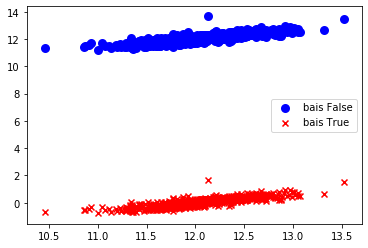

In [553]:
# scatterでプロット
plt.scatter(y_test_log, y_pred_scratch, linewidths="3", c='b', label='bais False')
plt.scatter(y_test_log, y_pred_scratch_no_bias, marker="x", c='r', label='bais True')
plt.legend()
plt.show()

傾きは正確に出せていそうだが、切片を出していないので、0を通る直線に近いものになっている。

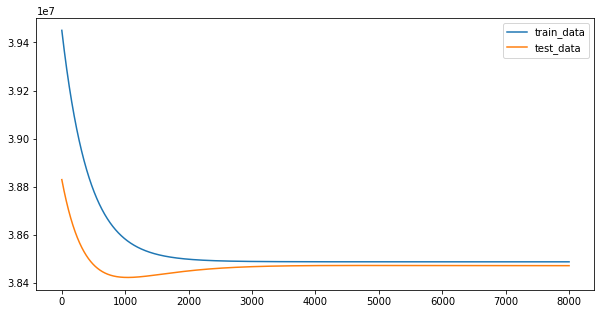

In [554]:
# 学習曲線のプロット
plt.figure(figsize=(10,5))
plt.plot([i for i in range(scratch_ver.iter)], scratch_no_bias.loss, label='train_data')
plt.plot([i for i in range(scratch_ver.iter)], scratch_no_bias.val_loss, label='test_data')
plt.legend()
plt.show()

# 【問題9】（アドバンス課題）特徴量の多次元化
特徴量の二乗や三乗を入力に利用すると学習結果がどう変化するか検証してください。

In [555]:
# GrLivAreaを二乗、yearbuildを三乗してみる

grliv2 = X[:,0] ** 2
grliv2 = grliv2.reshape(-1,1)
print(grliv2)
year3 = X[:,1] ** 3
year3 = year3.reshape(-1,1)
print(year3)



[[2924100]
 [1592644]
 [3189796]
 ...
 [5475600]
 [1162084]
 [1577536]]
[[8036054027]
 [7715442176]
 [8012006001]
 ...
 [7312680621]
 [7414875000]
 [7587307125]]


In [556]:
XX = np.hstack((X, grliv2, year3))
XX

array([[      1710,       2003,    2924100, 8036054027],
       [      1262,       1976,    1592644, 7715442176],
       [      1786,       2001,    3189796, 8012006001],
       ...,
       [      2340,       1941,    5475600, 7312680621],
       [      1078,       1950,    1162084, 7414875000],
       [      1256,       1965,    1577536, 7587307125]])

In [557]:
X_train, X_test, y_train, y_test = train_test_split( XX, y, train_size=0.5, random_state=50)
print(X_train, X_test, y_train, y_test)


# 標準化する

sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

[[      1268       1949    1607824 7403473349]
 [      2345       1932    5499025 7211429568]
 [       800       1936     640000 7256313856]
 ...
 [      1327       1959    1760929 7518017079]
 [      2599       1999    6754801 7988005999]
 [      1844       1977    3400336 7727161833]] [[      1466       2007    2149156 8084294343]
 [      1509       1988    2277081 7856862272]
 [      1302       1972    1695204 7668682048]
 ...
 [      1801       2005    3243601 8060150125]
 [       816       1982     665856 7785938168]
 [      1440       1955    2073600 7472058875]] [133000 239000  60000 172500 188700 377426 157000 107000 375000 128500
 208900 260000 200000 144000 111250 112000 131000 143000 173000 153337
 185500 192000 176500 175000 127500 150000 129900 320000 140000 269790
 136500 162000  76500 126000 179000 140000 146500 165000 172785  68400
 165000 176485 412500 128000 235000 240000  90000 133700 115000 160000
 179500 162900 220000 113000 289000 180000 163000 129000 241500 23500

In [560]:
scratch_feature_plus_ver = ScratchLinearRegression(num_iter=8000, lr=0.001, no_bias=False, verbose=True)
scratch_feature_plus_ver.fit(X_train_std,y_train_log)

iter : 0 [train_loss : 3.414428e+07]
iter : 1 [train_loss : 3.406850e+07]
iter : 2 [train_loss : 3.399292e+07]
iter : 3 [train_loss : 3.391752e+07]
iter : 4 [train_loss : 3.384231e+07]
iter : 5 [train_loss : 3.376728e+07]
iter : 6 [train_loss : 3.369244e+07]
iter : 7 [train_loss : 3.361778e+07]
iter : 8 [train_loss : 3.354331e+07]
iter : 9 [train_loss : 3.346902e+07]
iter : 10 [train_loss : 3.339492e+07]
iter : 11 [train_loss : 3.332100e+07]
iter : 12 [train_loss : 3.324726e+07]
iter : 13 [train_loss : 3.317370e+07]
iter : 14 [train_loss : 3.310032e+07]
iter : 15 [train_loss : 3.302712e+07]
iter : 16 [train_loss : 3.295411e+07]
iter : 17 [train_loss : 3.288127e+07]
iter : 18 [train_loss : 3.280861e+07]
iter : 19 [train_loss : 3.273613e+07]
iter : 20 [train_loss : 3.266383e+07]
iter : 21 [train_loss : 3.259170e+07]
iter : 22 [train_loss : 3.251976e+07]
iter : 23 [train_loss : 3.244799e+07]
iter : 24 [train_loss : 3.237639e+07]
iter : 25 [train_loss : 3.230497e+07]
iter : 26 [train_loss 

iter : 379 [train_loss : 1.517081e+07]
iter : 380 [train_loss : 1.513928e+07]
iter : 381 [train_loss : 1.510781e+07]
iter : 382 [train_loss : 1.507642e+07]
iter : 383 [train_loss : 1.504510e+07]
iter : 384 [train_loss : 1.501384e+07]
iter : 385 [train_loss : 1.498265e+07]
iter : 386 [train_loss : 1.495153e+07]
iter : 387 [train_loss : 1.492048e+07]
iter : 388 [train_loss : 1.488950e+07]
iter : 389 [train_loss : 1.485858e+07]
iter : 390 [train_loss : 1.482773e+07]
iter : 391 [train_loss : 1.479695e+07]
iter : 392 [train_loss : 1.476623e+07]
iter : 393 [train_loss : 1.473558e+07]
iter : 394 [train_loss : 1.470500e+07]
iter : 395 [train_loss : 1.467449e+07]
iter : 396 [train_loss : 1.464404e+07]
iter : 397 [train_loss : 1.461366e+07]
iter : 398 [train_loss : 1.458334e+07]
iter : 399 [train_loss : 1.455309e+07]
iter : 400 [train_loss : 1.452291e+07]
iter : 401 [train_loss : 1.449279e+07]
iter : 402 [train_loss : 1.446274e+07]
iter : 403 [train_loss : 1.443275e+07]
iter : 404 [train_loss : 

iter : 832 [train_loss : 6.007676e+06]
iter : 833 [train_loss : 5.995553e+06]
iter : 834 [train_loss : 5.983454e+06]
iter : 835 [train_loss : 5.971380e+06]
iter : 836 [train_loss : 5.959331e+06]
iter : 837 [train_loss : 5.947306e+06]
iter : 838 [train_loss : 5.935307e+06]
iter : 839 [train_loss : 5.923332e+06]
iter : 840 [train_loss : 5.911381e+06]
iter : 841 [train_loss : 5.899455e+06]
iter : 842 [train_loss : 5.887554e+06]
iter : 843 [train_loss : 5.875677e+06]
iter : 844 [train_loss : 5.863824e+06]
iter : 845 [train_loss : 5.851996e+06]
iter : 846 [train_loss : 5.840192e+06]
iter : 847 [train_loss : 5.828412e+06]
iter : 848 [train_loss : 5.816656e+06]
iter : 849 [train_loss : 5.804925e+06]
iter : 850 [train_loss : 5.793218e+06]
iter : 851 [train_loss : 5.781534e+06]
iter : 852 [train_loss : 5.769875e+06]
iter : 853 [train_loss : 5.758239e+06]
iter : 854 [train_loss : 5.746628e+06]
iter : 855 [train_loss : 5.735040e+06]
iter : 856 [train_loss : 5.723476e+06]
iter : 857 [train_loss : 

iter : 1371 [train_loss : 2.038761e+06]
iter : 1372 [train_loss : 2.034703e+06]
iter : 1373 [train_loss : 2.030653e+06]
iter : 1374 [train_loss : 2.026610e+06]
iter : 1375 [train_loss : 2.022576e+06]
iter : 1376 [train_loss : 2.018551e+06]
iter : 1377 [train_loss : 2.014533e+06]
iter : 1378 [train_loss : 2.010523e+06]
iter : 1379 [train_loss : 2.006522e+06]
iter : 1380 [train_loss : 2.002528e+06]
iter : 1381 [train_loss : 1.998543e+06]
iter : 1382 [train_loss : 1.994565e+06]
iter : 1383 [train_loss : 1.990595e+06]
iter : 1384 [train_loss : 1.986634e+06]
iter : 1385 [train_loss : 1.982680e+06]
iter : 1386 [train_loss : 1.978735e+06]
iter : 1387 [train_loss : 1.974797e+06]
iter : 1388 [train_loss : 1.970867e+06]
iter : 1389 [train_loss : 1.966946e+06]
iter : 1390 [train_loss : 1.963032e+06]
iter : 1391 [train_loss : 1.959126e+06]
iter : 1392 [train_loss : 1.955227e+06]
iter : 1393 [train_loss : 1.951337e+06]
iter : 1394 [train_loss : 1.947454e+06]
iter : 1395 [train_loss : 1.943580e+06]


iter : 1811 [train_loss : 8.523321e+05]
iter : 1812 [train_loss : 8.506550e+05]
iter : 1813 [train_loss : 8.489813e+05]
iter : 1814 [train_loss : 8.473109e+05]
iter : 1815 [train_loss : 8.456439e+05]
iter : 1816 [train_loss : 8.439803e+05]
iter : 1817 [train_loss : 8.423199e+05]
iter : 1818 [train_loss : 8.406629e+05]
iter : 1819 [train_loss : 8.390092e+05]
iter : 1820 [train_loss : 8.373588e+05]
iter : 1821 [train_loss : 8.357117e+05]
iter : 1822 [train_loss : 8.340680e+05]
iter : 1823 [train_loss : 8.324275e+05]
iter : 1824 [train_loss : 8.307903e+05]
iter : 1825 [train_loss : 8.291564e+05]
iter : 1826 [train_loss : 8.275257e+05]
iter : 1827 [train_loss : 8.258983e+05]
iter : 1828 [train_loss : 8.242742e+05]
iter : 1829 [train_loss : 8.226533e+05]
iter : 1830 [train_loss : 8.210357e+05]
iter : 1831 [train_loss : 8.194213e+05]
iter : 1832 [train_loss : 8.178101e+05]
iter : 1833 [train_loss : 8.162022e+05]
iter : 1834 [train_loss : 8.145975e+05]
iter : 1835 [train_loss : 8.129960e+05]


iter : 2298 [train_loss : 3.302580e+05]
iter : 2299 [train_loss : 3.296257e+05]
iter : 2300 [train_loss : 3.289947e+05]
iter : 2301 [train_loss : 3.283649e+05]
iter : 2302 [train_loss : 3.277364e+05]
iter : 2303 [train_loss : 3.271091e+05]
iter : 2304 [train_loss : 3.264831e+05]
iter : 2305 [train_loss : 3.258583e+05]
iter : 2306 [train_loss : 3.252348e+05]
iter : 2307 [train_loss : 3.246125e+05]
iter : 2308 [train_loss : 3.239915e+05]
iter : 2309 [train_loss : 3.233717e+05]
iter : 2310 [train_loss : 3.227531e+05]
iter : 2311 [train_loss : 3.221358e+05]
iter : 2312 [train_loss : 3.215197e+05]
iter : 2313 [train_loss : 3.209049e+05]
iter : 2314 [train_loss : 3.202913e+05]
iter : 2315 [train_loss : 3.196789e+05]
iter : 2316 [train_loss : 3.190677e+05]
iter : 2317 [train_loss : 3.184578e+05]
iter : 2318 [train_loss : 3.178491e+05]
iter : 2319 [train_loss : 3.172416e+05]
iter : 2320 [train_loss : 3.166353e+05]
iter : 2321 [train_loss : 3.160302e+05]
iter : 2322 [train_loss : 3.154263e+05]


iter : 2824 [train_loss : 1.243482e+05]
iter : 2825 [train_loss : 1.241275e+05]
iter : 2826 [train_loss : 1.239071e+05]
iter : 2827 [train_loss : 1.236873e+05]
iter : 2828 [train_loss : 1.234678e+05]
iter : 2829 [train_loss : 1.232488e+05]
iter : 2830 [train_loss : 1.230302e+05]
iter : 2831 [train_loss : 1.228121e+05]
iter : 2832 [train_loss : 1.225944e+05]
iter : 2833 [train_loss : 1.223771e+05]
iter : 2834 [train_loss : 1.221603e+05]
iter : 2835 [train_loss : 1.219439e+05]
iter : 2836 [train_loss : 1.217279e+05]
iter : 2837 [train_loss : 1.215124e+05]
iter : 2838 [train_loss : 1.212973e+05]
iter : 2839 [train_loss : 1.210826e+05]
iter : 2840 [train_loss : 1.208683e+05]
iter : 2841 [train_loss : 1.206545e+05]
iter : 2842 [train_loss : 1.204411e+05]
iter : 2843 [train_loss : 1.202281e+05]
iter : 2844 [train_loss : 1.200156e+05]
iter : 2845 [train_loss : 1.198035e+05]
iter : 2846 [train_loss : 1.195918e+05]
iter : 2847 [train_loss : 1.193805e+05]
iter : 2848 [train_loss : 1.191697e+05]


iter : 3331 [train_loss : 5.391601e+04]
iter : 3332 [train_loss : 5.383584e+04]
iter : 3333 [train_loss : 5.375583e+04]
iter : 3334 [train_loss : 5.367598e+04]
iter : 3335 [train_loss : 5.359629e+04]
iter : 3336 [train_loss : 5.351676e+04]
iter : 3337 [train_loss : 5.343739e+04]
iter : 3338 [train_loss : 5.335817e+04]
iter : 3339 [train_loss : 5.327911e+04]
iter : 3340 [train_loss : 5.320021e+04]
iter : 3341 [train_loss : 5.312147e+04]
iter : 3342 [train_loss : 5.304289e+04]
iter : 3343 [train_loss : 5.296446e+04]
iter : 3344 [train_loss : 5.288619e+04]
iter : 3345 [train_loss : 5.280807e+04]
iter : 3346 [train_loss : 5.273011e+04]
iter : 3347 [train_loss : 5.265231e+04]
iter : 3348 [train_loss : 5.257466e+04]
iter : 3349 [train_loss : 5.249717e+04]
iter : 3350 [train_loss : 5.241983e+04]
iter : 3351 [train_loss : 5.234264e+04]
iter : 3352 [train_loss : 5.226561e+04]
iter : 3353 [train_loss : 5.218873e+04]
iter : 3354 [train_loss : 5.211201e+04]
iter : 3355 [train_loss : 5.203543e+04]


iter : 3802 [train_loss : 2.940652e+04]
iter : 3803 [train_loss : 2.937516e+04]
iter : 3804 [train_loss : 2.934387e+04]
iter : 3805 [train_loss : 2.931264e+04]
iter : 3806 [train_loss : 2.928147e+04]
iter : 3807 [train_loss : 2.925036e+04]
iter : 3808 [train_loss : 2.921931e+04]
iter : 3809 [train_loss : 2.918833e+04]
iter : 3810 [train_loss : 2.915740e+04]
iter : 3811 [train_loss : 2.912654e+04]
iter : 3812 [train_loss : 2.909574e+04]
iter : 3813 [train_loss : 2.906500e+04]
iter : 3814 [train_loss : 2.903432e+04]
iter : 3815 [train_loss : 2.900371e+04]
iter : 3816 [train_loss : 2.897315e+04]
iter : 3817 [train_loss : 2.894265e+04]
iter : 3818 [train_loss : 2.891222e+04]
iter : 3819 [train_loss : 2.888184e+04]
iter : 3820 [train_loss : 2.885153e+04]
iter : 3821 [train_loss : 2.882127e+04]
iter : 3822 [train_loss : 2.879108e+04]
iter : 3823 [train_loss : 2.876095e+04]
iter : 3824 [train_loss : 2.873087e+04]
iter : 3825 [train_loss : 2.870086e+04]
iter : 3826 [train_loss : 2.867090e+04]


iter : 4332 [train_loss : 1.911393e+04]
iter : 4333 [train_loss : 1.910295e+04]
iter : 4334 [train_loss : 1.909199e+04]
iter : 4335 [train_loss : 1.908106e+04]
iter : 4336 [train_loss : 1.907014e+04]
iter : 4337 [train_loss : 1.905925e+04]
iter : 4338 [train_loss : 1.904838e+04]
iter : 4339 [train_loss : 1.903753e+04]
iter : 4340 [train_loss : 1.902670e+04]
iter : 4341 [train_loss : 1.901589e+04]
iter : 4342 [train_loss : 1.900510e+04]
iter : 4343 [train_loss : 1.899434e+04]
iter : 4344 [train_loss : 1.898360e+04]
iter : 4345 [train_loss : 1.897287e+04]
iter : 4346 [train_loss : 1.896217e+04]
iter : 4347 [train_loss : 1.895149e+04]
iter : 4348 [train_loss : 1.894083e+04]
iter : 4349 [train_loss : 1.893019e+04]
iter : 4350 [train_loss : 1.891957e+04]
iter : 4351 [train_loss : 1.890898e+04]
iter : 4352 [train_loss : 1.889840e+04]
iter : 4353 [train_loss : 1.888784e+04]
iter : 4354 [train_loss : 1.887731e+04]
iter : 4355 [train_loss : 1.886680e+04]
iter : 4356 [train_loss : 1.885630e+04]


iter : 4956 [train_loss : 1.515004e+04]
iter : 4957 [train_loss : 1.514676e+04]
iter : 4958 [train_loss : 1.514349e+04]
iter : 4959 [train_loss : 1.514023e+04]
iter : 4960 [train_loss : 1.513698e+04]
iter : 4961 [train_loss : 1.513373e+04]
iter : 4962 [train_loss : 1.513048e+04]
iter : 4963 [train_loss : 1.512725e+04]
iter : 4964 [train_loss : 1.512402e+04]
iter : 4965 [train_loss : 1.512079e+04]
iter : 4966 [train_loss : 1.511757e+04]
iter : 4967 [train_loss : 1.511436e+04]
iter : 4968 [train_loss : 1.511115e+04]
iter : 4969 [train_loss : 1.510795e+04]
iter : 4970 [train_loss : 1.510476e+04]
iter : 4971 [train_loss : 1.510157e+04]
iter : 4972 [train_loss : 1.509839e+04]
iter : 4973 [train_loss : 1.509521e+04]
iter : 4974 [train_loss : 1.509204e+04]
iter : 4975 [train_loss : 1.508887e+04]
iter : 4976 [train_loss : 1.508572e+04]
iter : 4977 [train_loss : 1.508256e+04]
iter : 4978 [train_loss : 1.507942e+04]
iter : 4979 [train_loss : 1.507628e+04]
iter : 4980 [train_loss : 1.507314e+04]


iter : 5512 [train_loss : 1.401384e+04]
iter : 5513 [train_loss : 1.401265e+04]
iter : 5514 [train_loss : 1.401147e+04]
iter : 5515 [train_loss : 1.401029e+04]
iter : 5516 [train_loss : 1.400911e+04]
iter : 5517 [train_loss : 1.400793e+04]
iter : 5518 [train_loss : 1.400675e+04]
iter : 5519 [train_loss : 1.400558e+04]
iter : 5520 [train_loss : 1.400440e+04]
iter : 5521 [train_loss : 1.400323e+04]
iter : 5522 [train_loss : 1.400207e+04]
iter : 5523 [train_loss : 1.400090e+04]
iter : 5524 [train_loss : 1.399974e+04]
iter : 5525 [train_loss : 1.399857e+04]
iter : 5526 [train_loss : 1.399741e+04]
iter : 5527 [train_loss : 1.399625e+04]
iter : 5528 [train_loss : 1.399510e+04]
iter : 5529 [train_loss : 1.399394e+04]
iter : 5530 [train_loss : 1.399279e+04]
iter : 5531 [train_loss : 1.399164e+04]
iter : 5532 [train_loss : 1.399049e+04]
iter : 5533 [train_loss : 1.398935e+04]
iter : 5534 [train_loss : 1.398820e+04]
iter : 5535 [train_loss : 1.398706e+04]
iter : 5536 [train_loss : 1.398592e+04]


iter : 5998 [train_loss : 1.361714e+04]
iter : 5999 [train_loss : 1.361660e+04]
iter : 6000 [train_loss : 1.361605e+04]
iter : 6001 [train_loss : 1.361551e+04]
iter : 6002 [train_loss : 1.361496e+04]
iter : 6003 [train_loss : 1.361442e+04]
iter : 6004 [train_loss : 1.361388e+04]
iter : 6005 [train_loss : 1.361334e+04]
iter : 6006 [train_loss : 1.361280e+04]
iter : 6007 [train_loss : 1.361226e+04]
iter : 6008 [train_loss : 1.361172e+04]
iter : 6009 [train_loss : 1.361118e+04]
iter : 6010 [train_loss : 1.361065e+04]
iter : 6011 [train_loss : 1.361011e+04]
iter : 6012 [train_loss : 1.360957e+04]
iter : 6013 [train_loss : 1.360904e+04]
iter : 6014 [train_loss : 1.360851e+04]
iter : 6015 [train_loss : 1.360797e+04]
iter : 6016 [train_loss : 1.360744e+04]
iter : 6017 [train_loss : 1.360691e+04]
iter : 6018 [train_loss : 1.360638e+04]
iter : 6019 [train_loss : 1.360585e+04]
iter : 6020 [train_loss : 1.360532e+04]
iter : 6021 [train_loss : 1.360479e+04]
iter : 6022 [train_loss : 1.360426e+04]


iter : 6500 [train_loss : 1.341647e+04]
iter : 6501 [train_loss : 1.341618e+04]
iter : 6502 [train_loss : 1.341589e+04]
iter : 6503 [train_loss : 1.341559e+04]
iter : 6504 [train_loss : 1.341530e+04]
iter : 6505 [train_loss : 1.341501e+04]
iter : 6506 [train_loss : 1.341472e+04]
iter : 6507 [train_loss : 1.341443e+04]
iter : 6508 [train_loss : 1.341413e+04]
iter : 6509 [train_loss : 1.341384e+04]
iter : 6510 [train_loss : 1.341355e+04]
iter : 6511 [train_loss : 1.341326e+04]
iter : 6512 [train_loss : 1.341297e+04]
iter : 6513 [train_loss : 1.341268e+04]
iter : 6514 [train_loss : 1.341239e+04]
iter : 6515 [train_loss : 1.341210e+04]
iter : 6516 [train_loss : 1.341181e+04]
iter : 6517 [train_loss : 1.341152e+04]
iter : 6518 [train_loss : 1.341123e+04]
iter : 6519 [train_loss : 1.341095e+04]
iter : 6520 [train_loss : 1.341066e+04]
iter : 6521 [train_loss : 1.341037e+04]
iter : 6522 [train_loss : 1.341008e+04]
iter : 6523 [train_loss : 1.340980e+04]
iter : 6524 [train_loss : 1.340951e+04]


iter : 7014 [train_loss : 1.329477e+04]
iter : 7015 [train_loss : 1.329457e+04]
iter : 7016 [train_loss : 1.329438e+04]
iter : 7017 [train_loss : 1.329418e+04]
iter : 7018 [train_loss : 1.329399e+04]
iter : 7019 [train_loss : 1.329379e+04]
iter : 7020 [train_loss : 1.329360e+04]
iter : 7021 [train_loss : 1.329340e+04]
iter : 7022 [train_loss : 1.329321e+04]
iter : 7023 [train_loss : 1.329302e+04]
iter : 7024 [train_loss : 1.329282e+04]
iter : 7025 [train_loss : 1.329263e+04]
iter : 7026 [train_loss : 1.329243e+04]
iter : 7027 [train_loss : 1.329224e+04]
iter : 7028 [train_loss : 1.329205e+04]
iter : 7029 [train_loss : 1.329185e+04]
iter : 7030 [train_loss : 1.329166e+04]
iter : 7031 [train_loss : 1.329147e+04]
iter : 7032 [train_loss : 1.329127e+04]
iter : 7033 [train_loss : 1.329108e+04]
iter : 7034 [train_loss : 1.329089e+04]
iter : 7035 [train_loss : 1.329069e+04]
iter : 7036 [train_loss : 1.329050e+04]
iter : 7037 [train_loss : 1.329031e+04]
iter : 7038 [train_loss : 1.329012e+04]


iter : 7533 [train_loss : 1.320536e+04]
iter : 7534 [train_loss : 1.320521e+04]
iter : 7535 [train_loss : 1.320505e+04]
iter : 7536 [train_loss : 1.320490e+04]
iter : 7537 [train_loss : 1.320474e+04]
iter : 7538 [train_loss : 1.320459e+04]
iter : 7539 [train_loss : 1.320443e+04]
iter : 7540 [train_loss : 1.320428e+04]
iter : 7541 [train_loss : 1.320412e+04]
iter : 7542 [train_loss : 1.320397e+04]
iter : 7543 [train_loss : 1.320381e+04]
iter : 7544 [train_loss : 1.320366e+04]
iter : 7545 [train_loss : 1.320351e+04]
iter : 7546 [train_loss : 1.320335e+04]
iter : 7547 [train_loss : 1.320320e+04]
iter : 7548 [train_loss : 1.320304e+04]
iter : 7549 [train_loss : 1.320289e+04]
iter : 7550 [train_loss : 1.320273e+04]
iter : 7551 [train_loss : 1.320258e+04]
iter : 7552 [train_loss : 1.320243e+04]
iter : 7553 [train_loss : 1.320227e+04]
iter : 7554 [train_loss : 1.320212e+04]
iter : 7555 [train_loss : 1.320196e+04]
iter : 7556 [train_loss : 1.320181e+04]
iter : 7557 [train_loss : 1.320166e+04]


array([ 1.20130479e+01,  2.23728489e-01, -9.73413458e-01, -3.68545252e-03,
        1.16271877e+00])

In [561]:
# fitで得た係数を使って予測
print(scratch_ver.coef_)
y_pred_scratch_feature_plus = scratch_feature_plus_ver.predict(X_test_std)
y_pred_scratch_feature_plus

[12.01310515  0.23684467  0.18591667]


array([12.23900836, 12.11483988, 11.91899911, 11.5793253 , 12.43923778,
       12.26046735, 11.87660271, 11.95806811, 11.82308196, 12.17273104,
       11.67487552, 12.15643049, 11.2680236 , 12.17951764, 12.34996443,
       12.28629128, 12.03056439, 12.12367117, 12.39070763, 11.89943983,
       12.05865079, 12.47999887, 11.642951  , 12.25709712, 11.81406542,
       12.15618256, 12.31366045, 11.68905995, 12.41836913, 12.37899024,
       11.78592836, 11.77355072, 12.28758002, 11.73465096, 11.84390811,
       11.78337359, 12.32496343, 12.31774098, 11.42894499, 11.71575458,
       11.60746726, 12.21918012, 11.87795896, 11.98619273, 11.79806235,
       12.50532304, 11.88020642, 12.25376365, 12.23209153, 12.32245745,
       12.43462354, 12.31927838, 12.10607769, 11.94787069, 12.58118544,
       12.31708282, 11.76097842, 11.68416099, 12.75025446, 12.85966339,
       11.84350124, 12.00998418, 12.16022421, 11.91251846, 12.52985178,
       11.9889479 , 11.60633789, 12.22986828, 11.71775423, 11.76

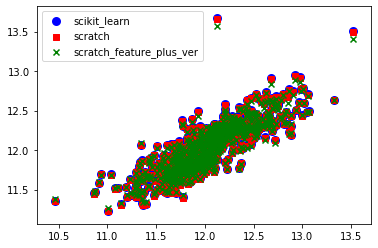

In [569]:
# scatterでプロットしてみる

plt.scatter(y_test_log, y_pred, linewidths="3", c='b', label='scikit_learn')
plt.scatter(y_test_log, y_pred_scratch, marker="s", c='r', label='scratch')
plt.scatter(y_test_log, y_pred_scratch_feature_plus, marker="x", c="g", label='scratch_feature_plus_ver' )
plt.legend()
plt.show()

特徴量を追加したところ、微妙にコンプレッションされている。